# Lightgbm Prediction Model

## Data Cleaning and Preparation

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
def feature_creation(df):
    # Adding features
    df["renewed"] = df.renewal_status.isin(["Renewed", "Transfered"]).astype(int)
    df["expiry_date"] = pd.to_datetime(df["expiry_date"])

    # Create mxdomain_cat feature
    extensions = df.mxdomain.dropna().str.extract(".*?((?:\..*)+)")[0]
    vc = extensions.value_counts(normalize=True)
    common_extensions = vc[vc > 0.01].index
    df["mxdomain_cat"] = np.nan
    df.loc[df.mxdomain.isna(), "mxdomain_cat"] = "missing"
    df.loc[df.mxdomain == df.nameserver, "mxdomain_cat"] = "nameserver"
    df.loc[df.mxdomain == df.domain, "mxdomain_cat"] = "domain"
    rlower = df.reseller.str.lower()
    df.loc[df.mxdomain == rlower, "mxdomain_cat"] = "reseller"
    for extension in common_extensions:
        df.loc[df.mxdomain == rlower + extension, "mxdomain_cat"] = "reseller"

    # Create months since start feature
    df["months_since_start"] = 12 * (df.expiry_date.dt.year - df.expiry_date.min().year) + (df.expiry_date.dt.month - df.expiry_date.min().month)

    return df

def convert_dtypes(df):
    # Convert string to categorical
    cat_cols = df.columns[df.dtypes == "O"]
    df[cat_cols] = df[cat_cols].astype("category")


    # Convert Pandas int to float
    int_cols = df.columns[df.dtypes == "Int64"]
    df[int_cols] = df[int_cols].astype(float)

    # Convert bool to float
    bool_cols = df.columns[df.dtypes == "boolean"]
    df[bool_cols] = df[bool_cols].astype(float)

    return df


In [3]:
read_bq = False  # Whether to read in table from bq or local

# Where to read from/save to
datapath = Path("/home/jupyter/Domains_202003/data/output/dp_datapull_20220930")

if read_bq:

    # Change these as necessary
    # proj_name = "myriad-303821"
    # dataset = "expiry"
    # table_name = "expiry_20170101_20220930_test"
    proj_name = "radixbi-249015"
    dataset = "prediction_vendors"
    table_name = "expiry_data_with_npv_dp_data_2022_03_14"

    # Read in data
    query = f"select * from `{dataset}.{table_name}`"
    df = pd.read_gbq(
        query, project_id=proj_name, progress_bar_type="tqdm_notebook",
        use_bqstorage_api=False,
    )
    # df = pd.read_csv(datapath / "expiry_20170101_20220930_test.csv")
    
    # Generate features
    df = feature_creation(df)

    # Save for future use
    df.to_feather(datapath / "expiry_data_with_npv_and_dp_data_vw.ftr")
    df.to_csv(datapath / "expiry_data_with_npv_and_dp_data_vw.csv")
    
else:
    # Read in local file
    # df = pd.read_feather(datapath / "expiry_data_with_npv_and_dp_data_vw.ftr")
    df = pd.read_csv(datapath / "expiry_data_with_npv_and_dp_data_vw.csv")


In [4]:
df.expiry_date = pd.to_datetime(df.expiry_date)

In [17]:
mask = df.expiry_date < "2022-01-01"
df.loc[mask, ["ssl", "renewed"]].isna().mean()
tmp = df.sample(100000).copy()
tmp['ssl'] = tmp['ssl'].fillna(-1)


<AxesSubplot:xlabel='expiry_date'>

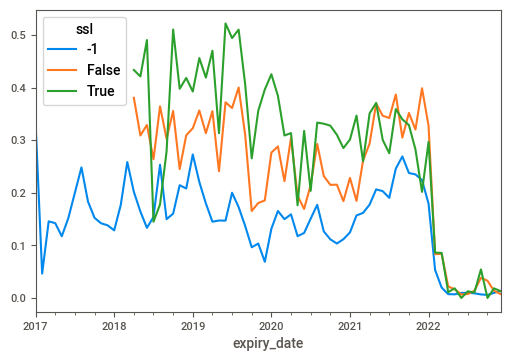

In [20]:
mask = tmp.expiry_date < "2023-01-01"

piv = pd.pivot_table(tmp[mask], index=pd.Grouper(key="expiry_date", freq="MS"), columns="ssl", values="renewed", aggfunc="mean")
piv.plot()
# tmp.groupby("ssl")["renewed"].mean()
# pd.crosstab(df.loc[mask, "ssl"], df.loc[mask, "renewed"])

In [9]:
non_dp_features = [
    'renewed_count', 'tld', 'reseller', 'reseller_country', 'reg_period',
    'reg_arpt', 'gibb_score', 'pattern_domain_count', 'day_domains', 'sld_length', 'sld_type',
    'sld_type2', 'predictions_renewal_type', 'months_since_start'
]

dp_features = ["country", "economy_footprint", "response", "websitetype", "hosting_country", 'mxdomain_cat', 'ssl', 'promo_tag']
verbose = 1

features = list(non_dp_features)

X = df[features+dp_features + ["expiry_date"]].copy()
X = convert_dtypes(X)

In [13]:
mask = X.reseller.isin(X.reseller.value_counts().index[:50])
X_ = X[mask].copy()


In [7]:
plt.style.use("ERI_template")

                                             |          | [  0%]   00:00 -> (? left)


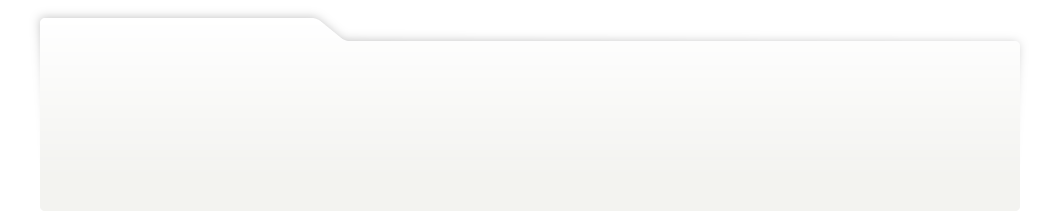
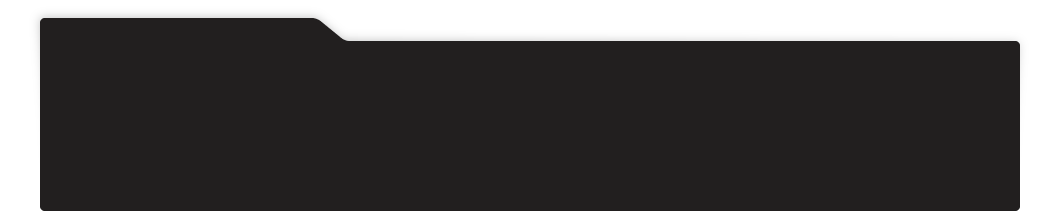
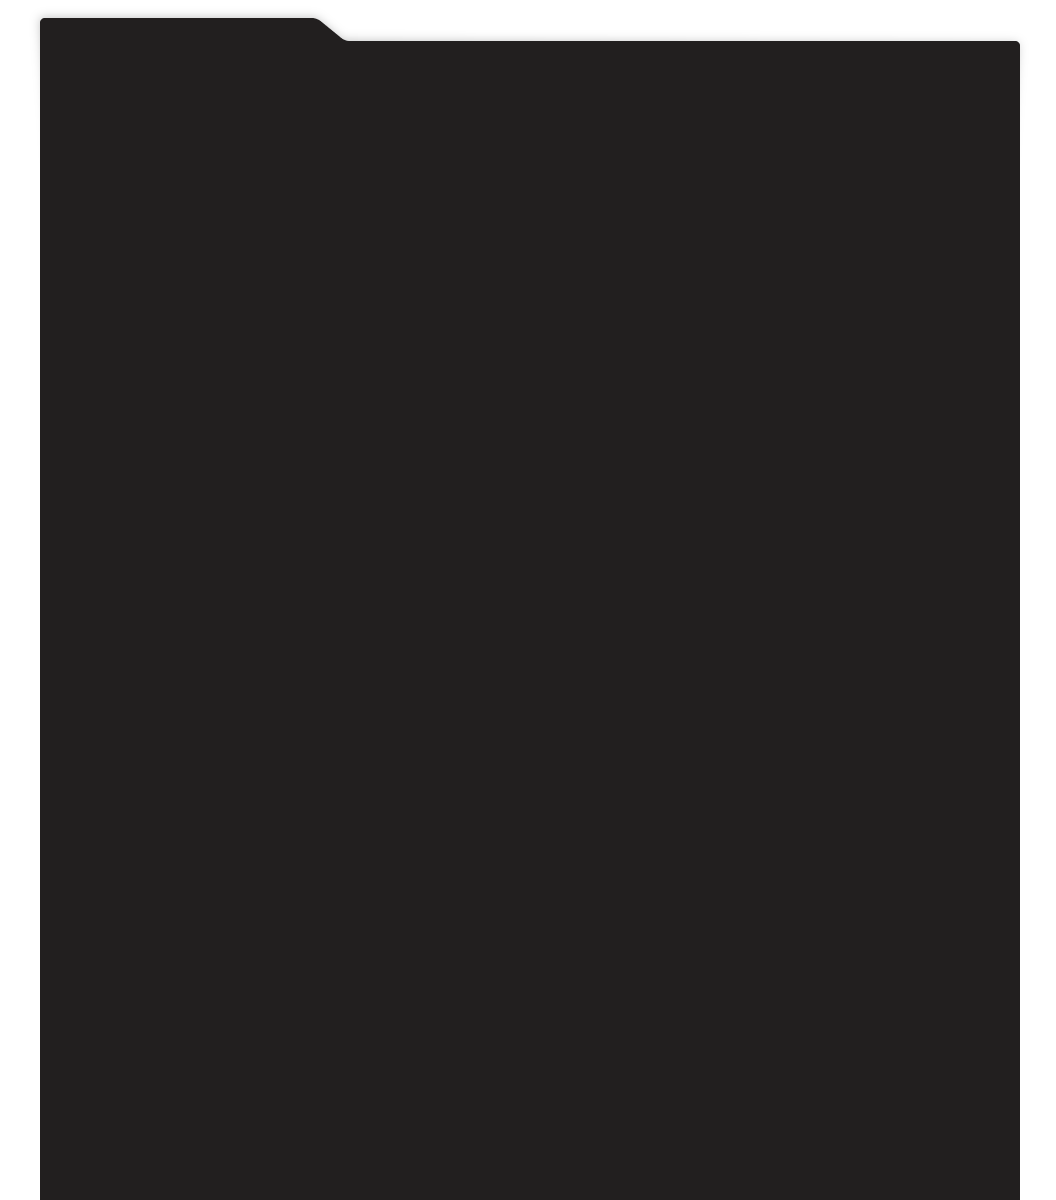
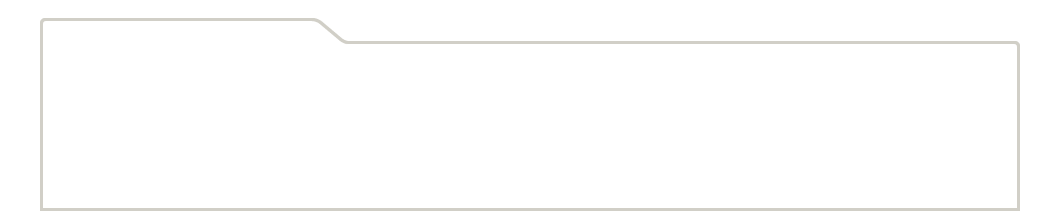
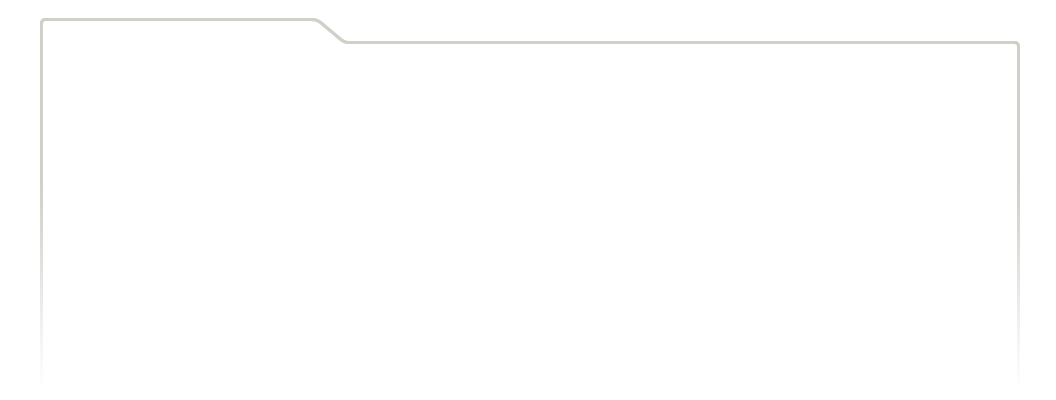
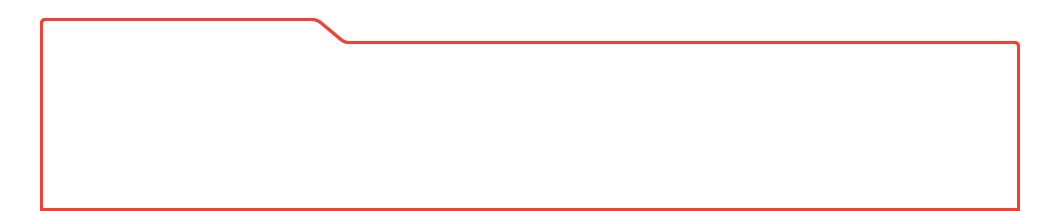
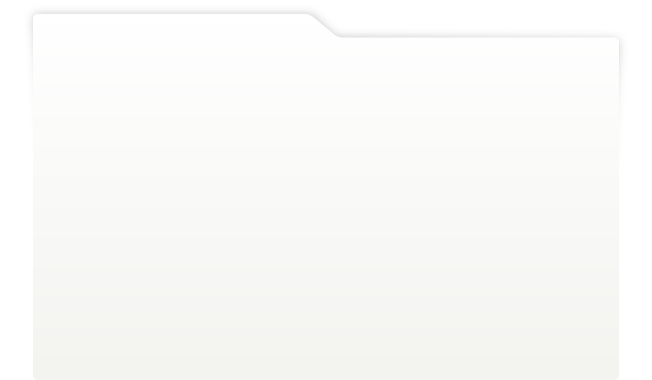
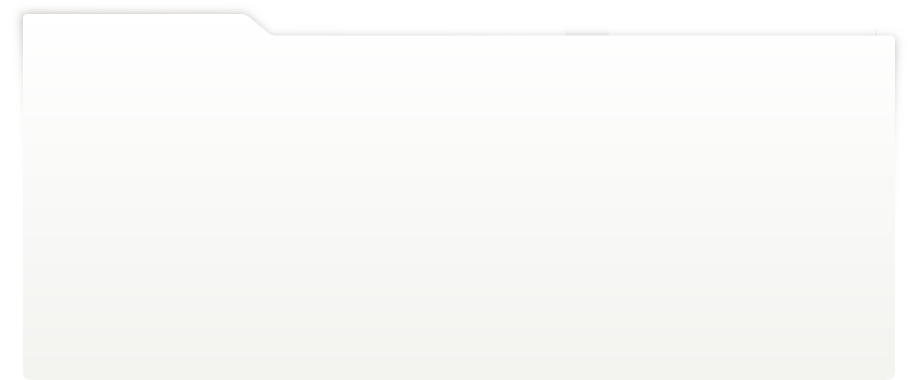
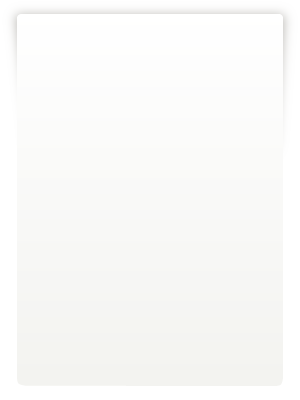
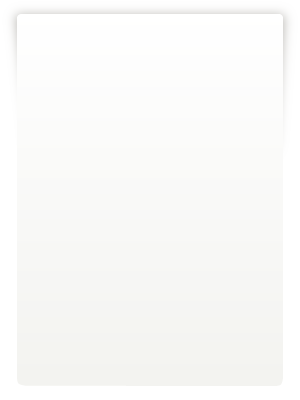
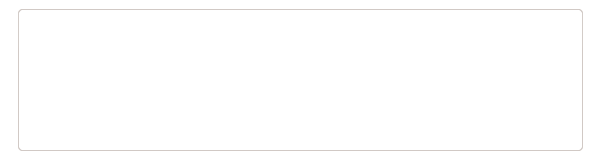
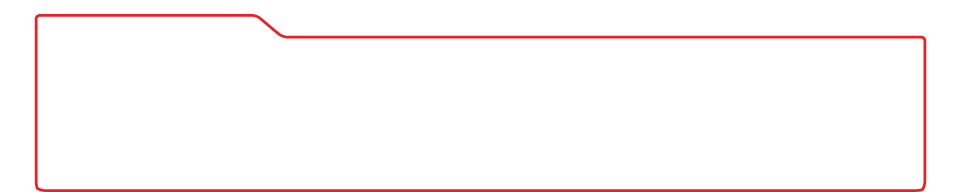
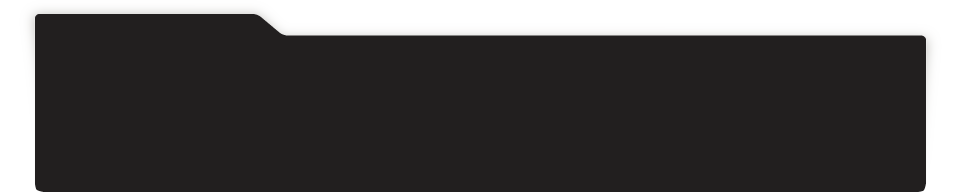
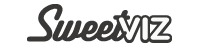
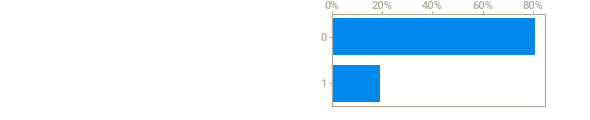
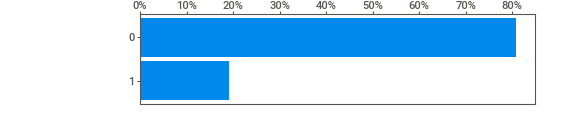
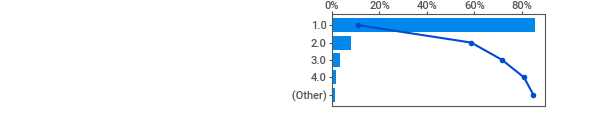
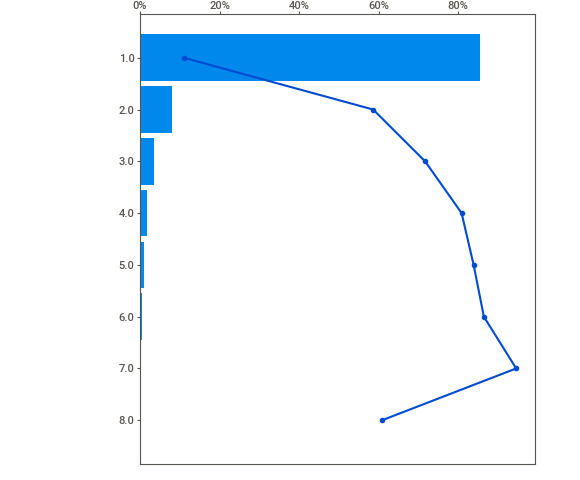
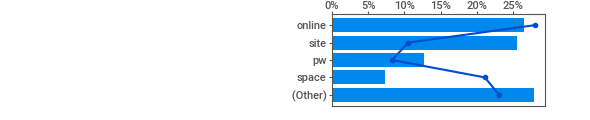
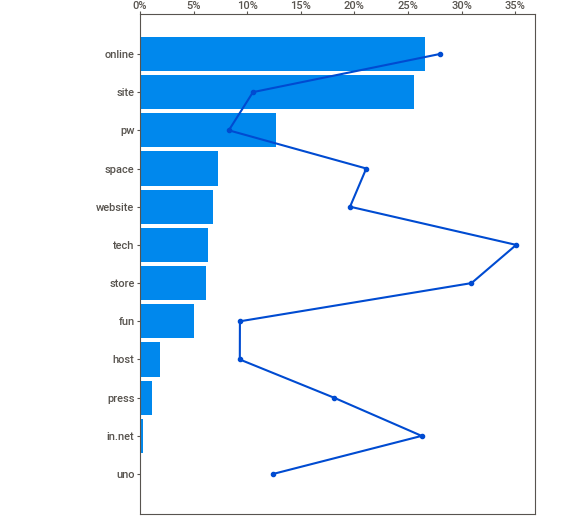
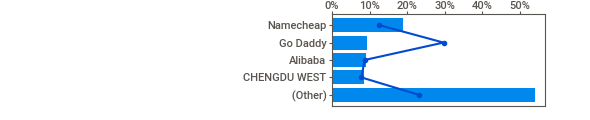
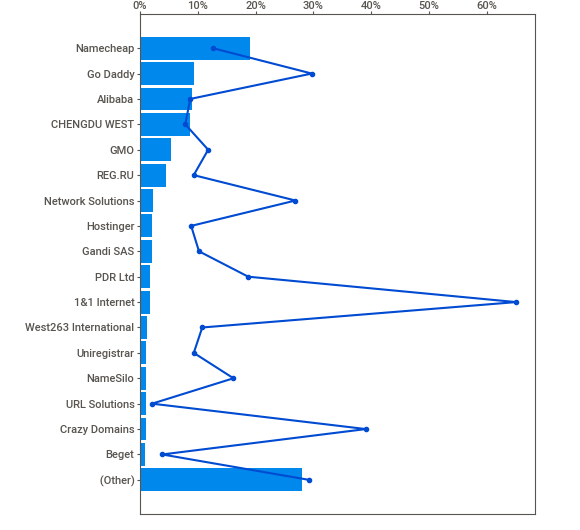
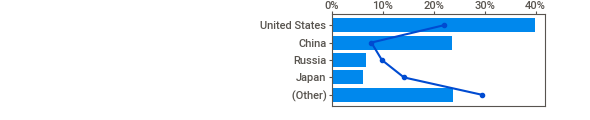
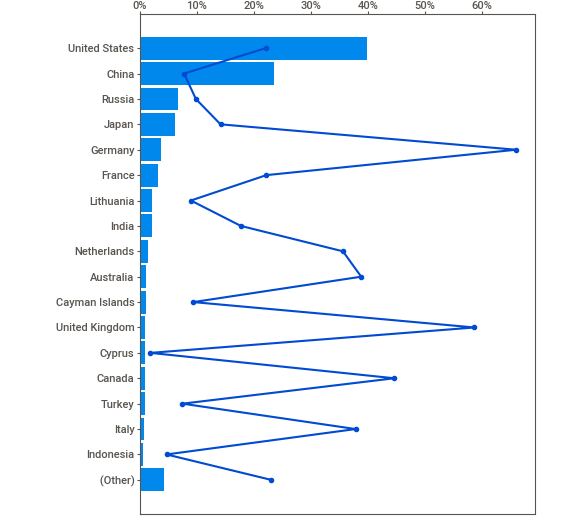
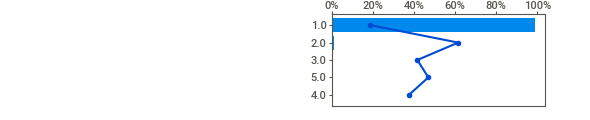
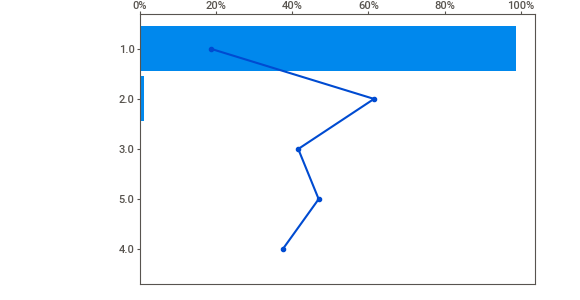
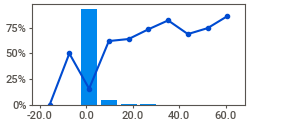
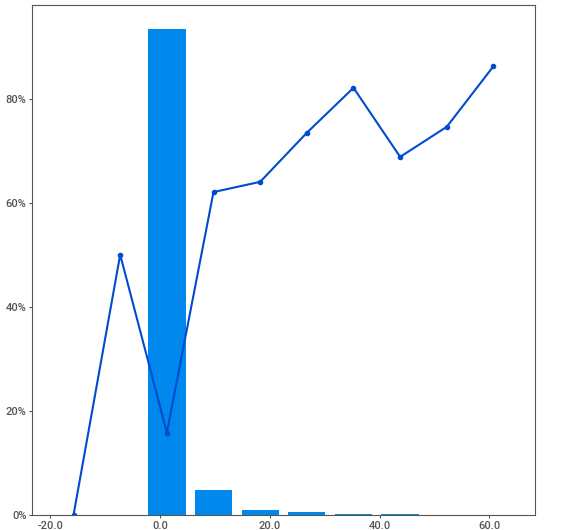
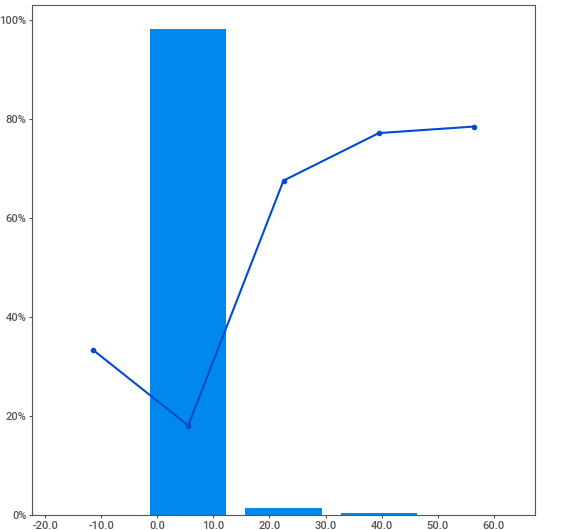
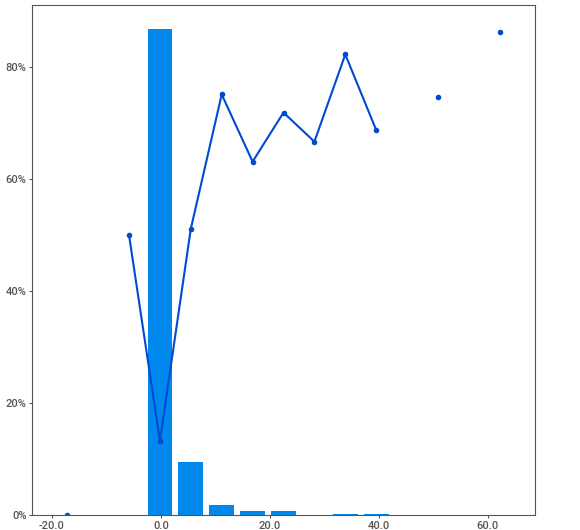
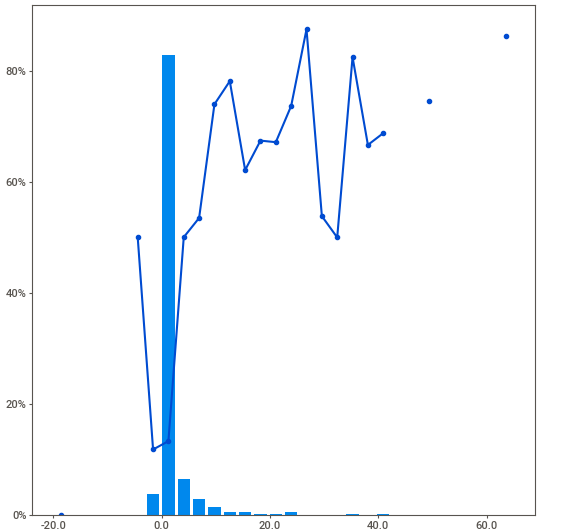
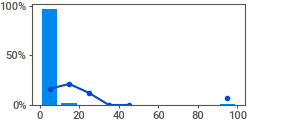
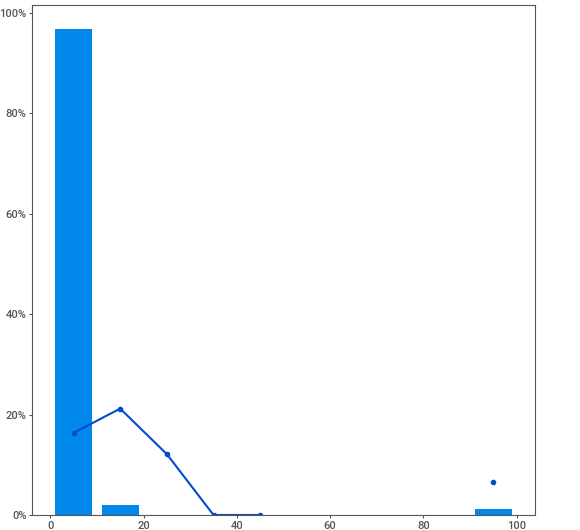
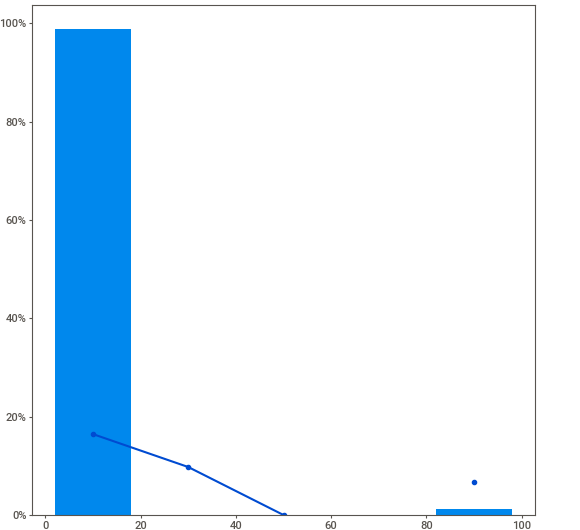
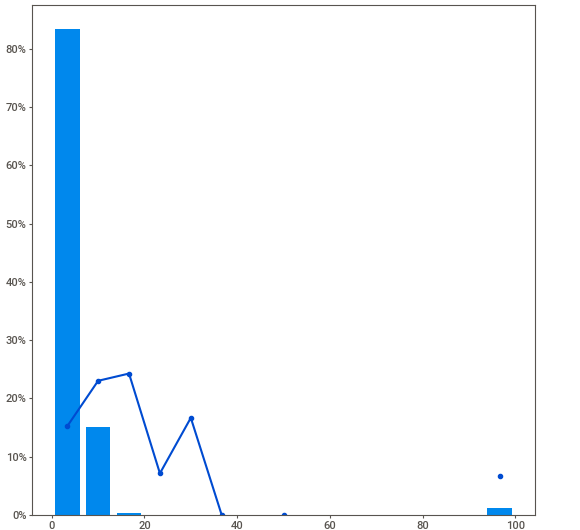
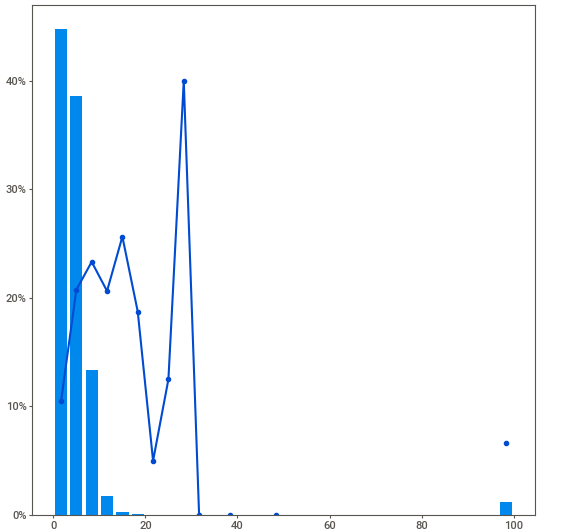
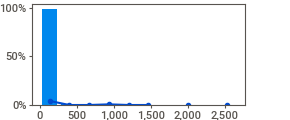
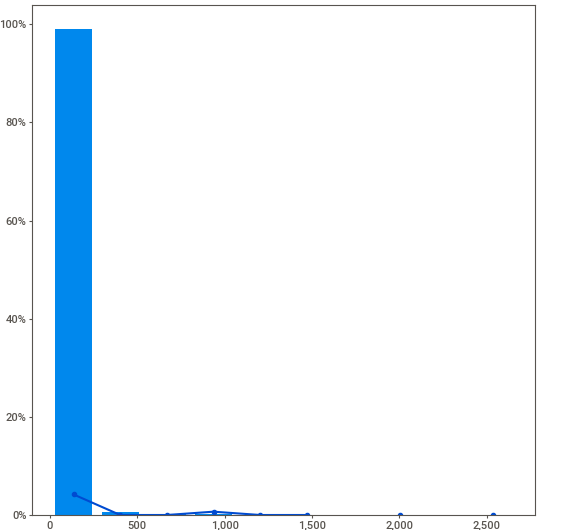
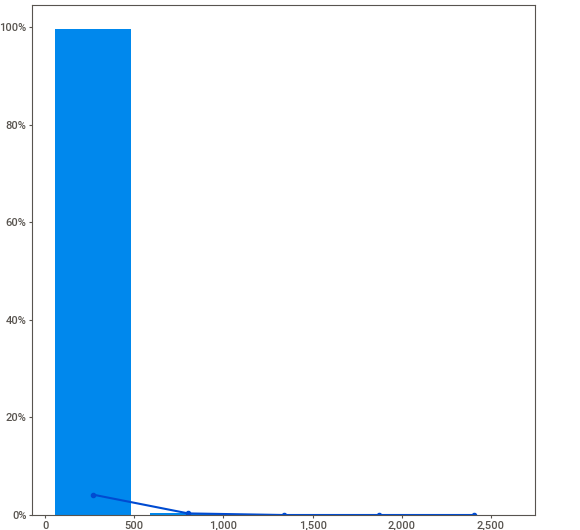
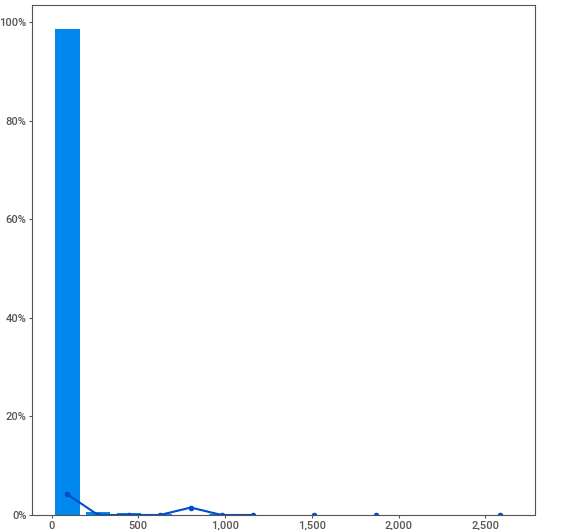
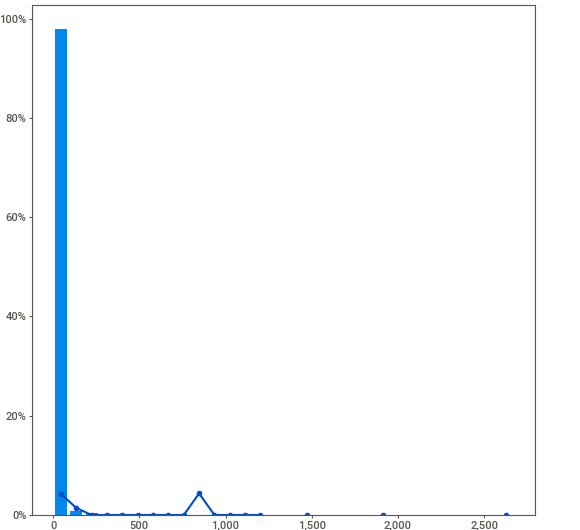
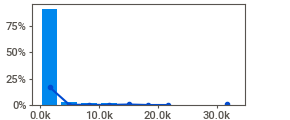
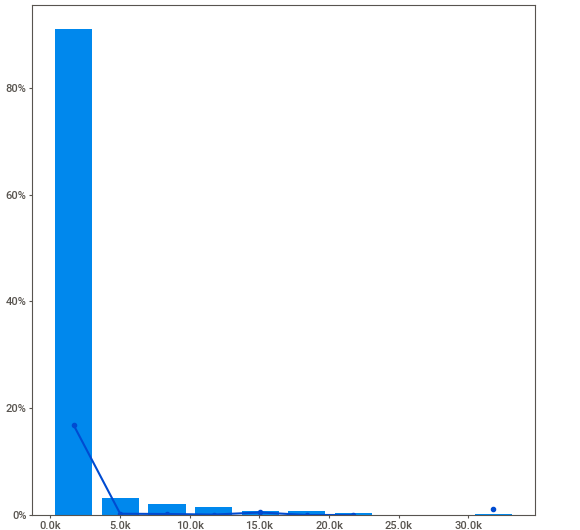
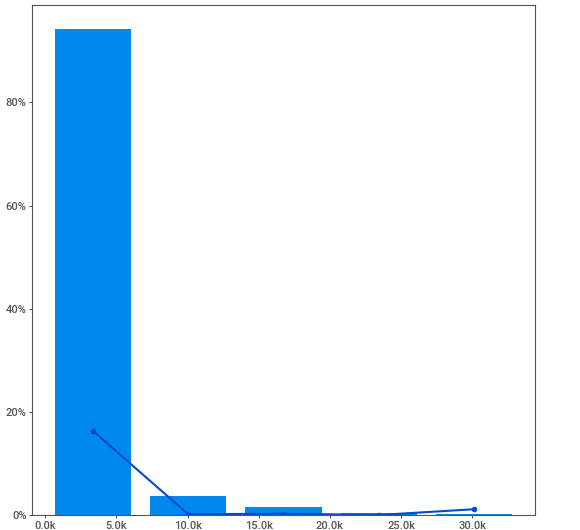
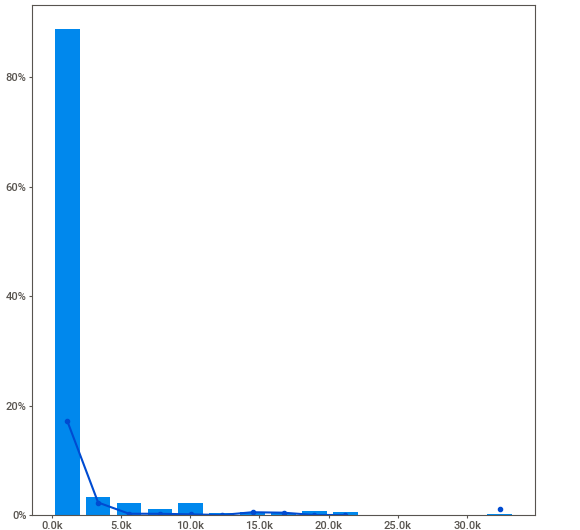
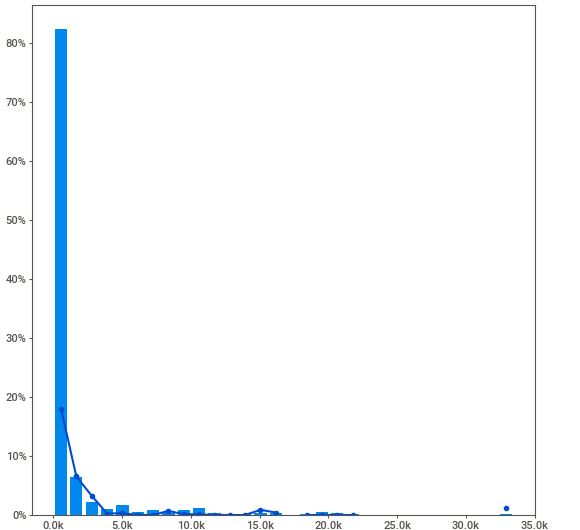
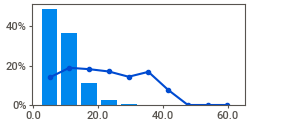
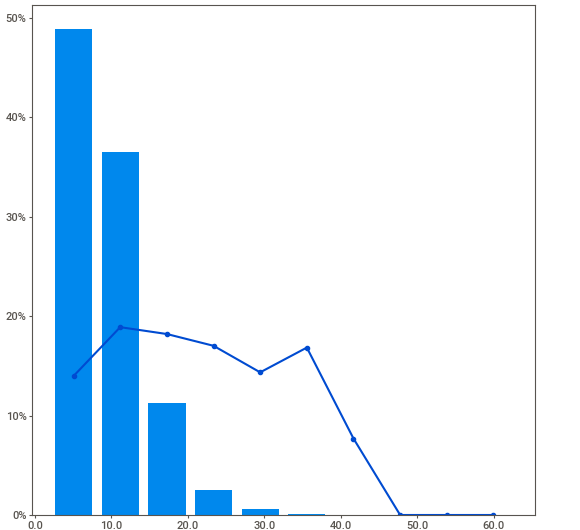
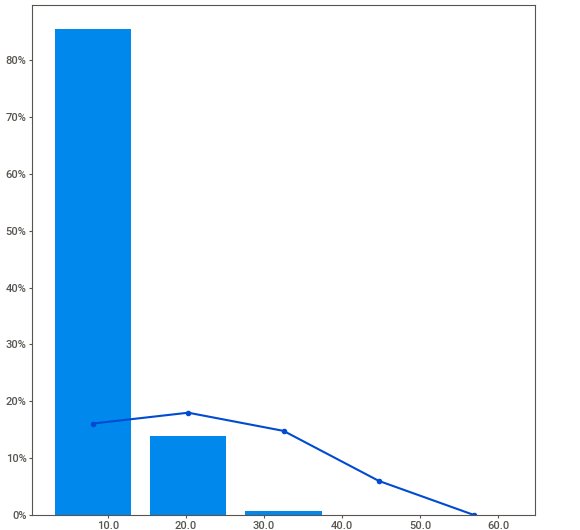
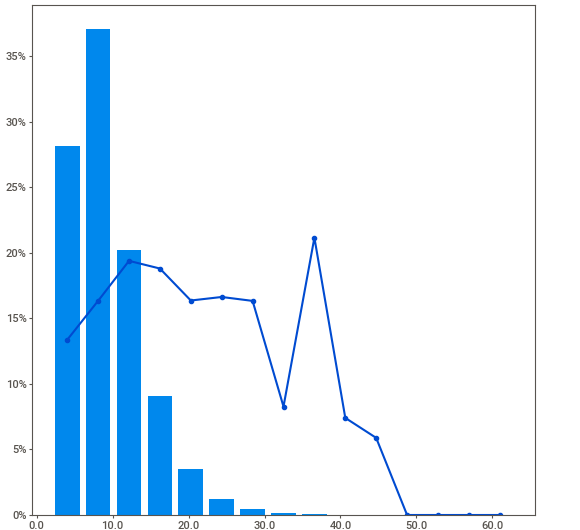
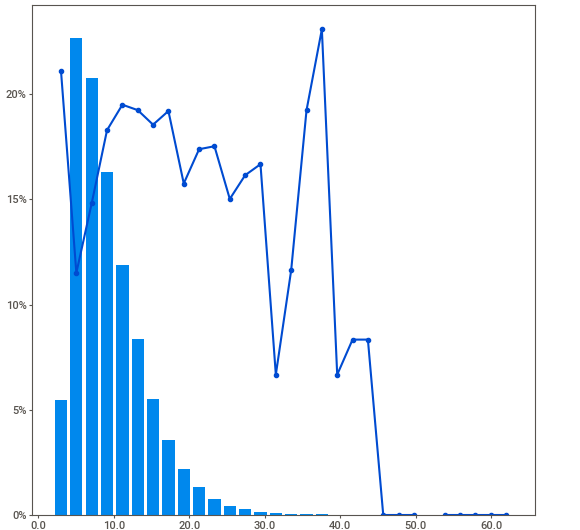
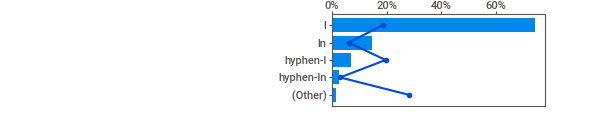
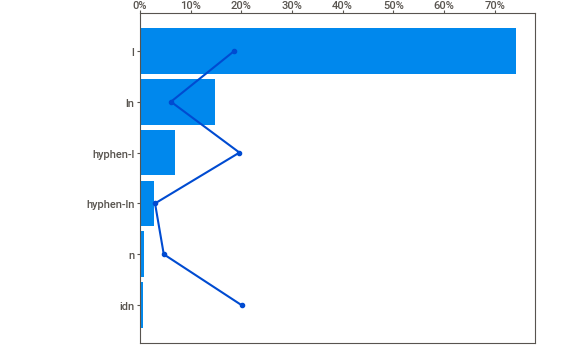
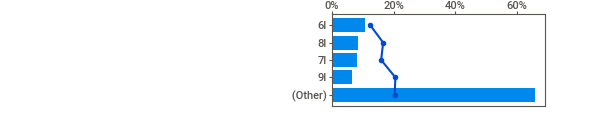
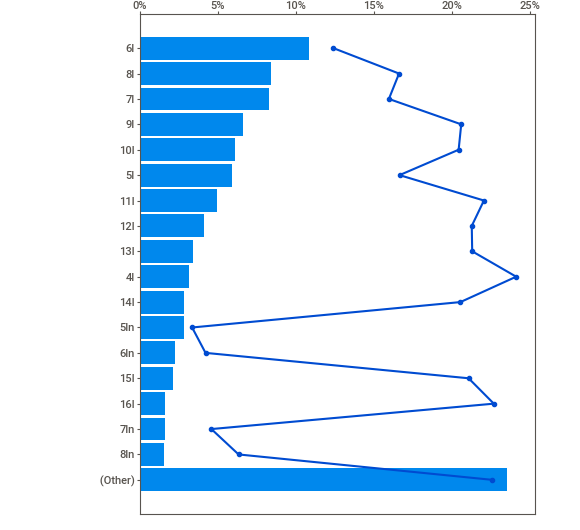
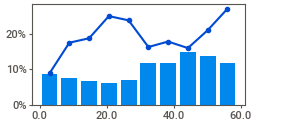
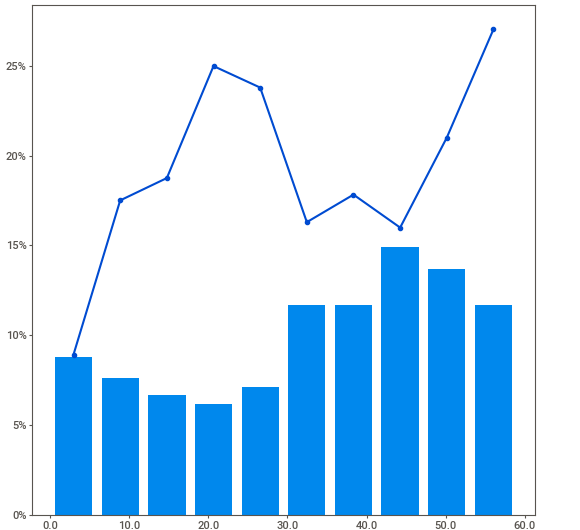
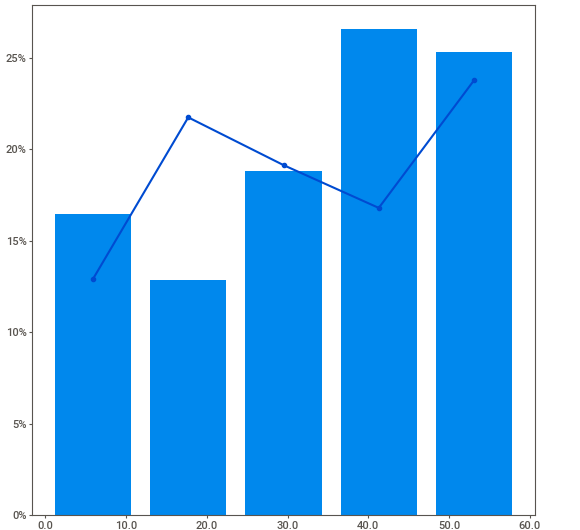
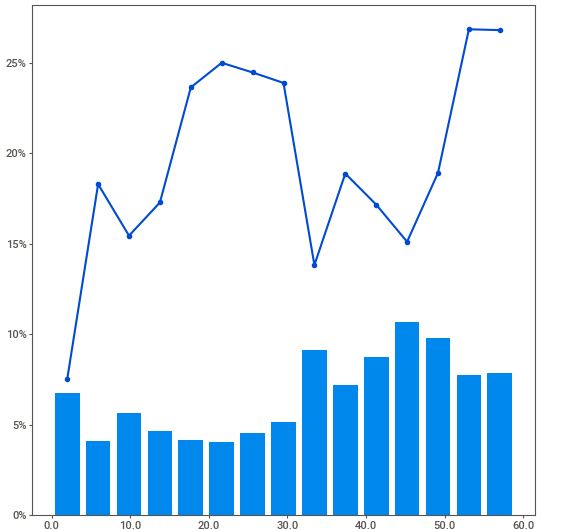
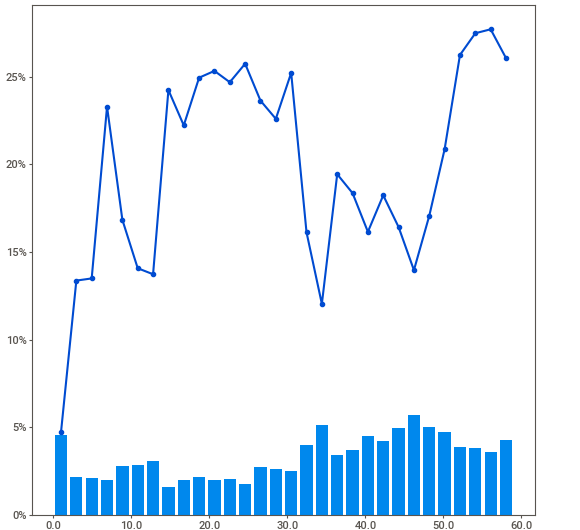
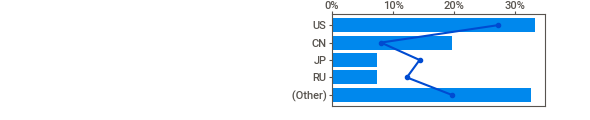
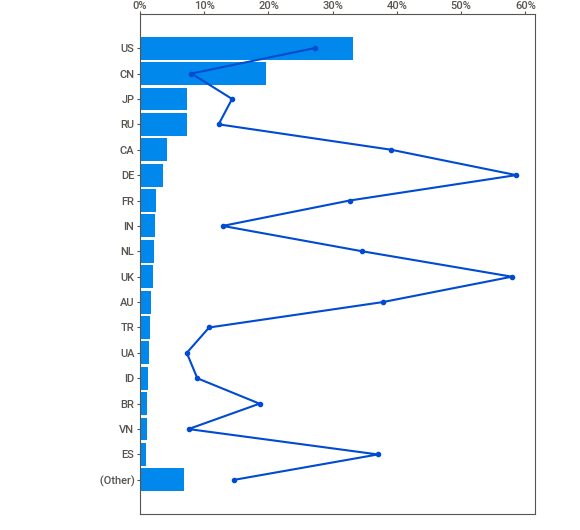
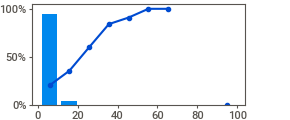
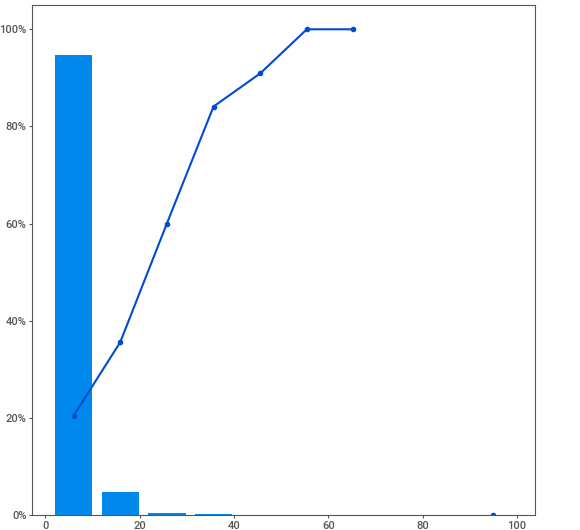
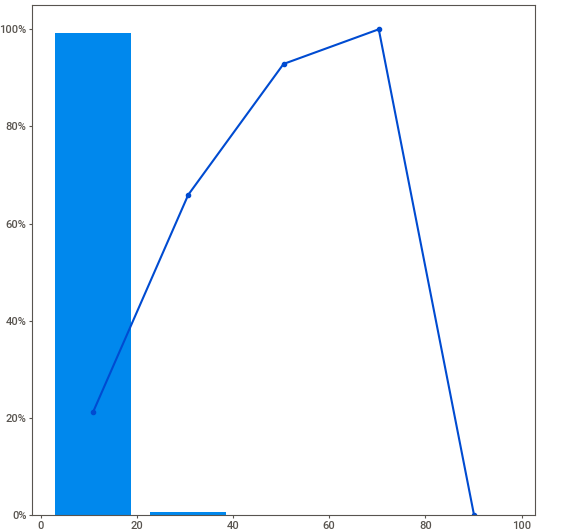
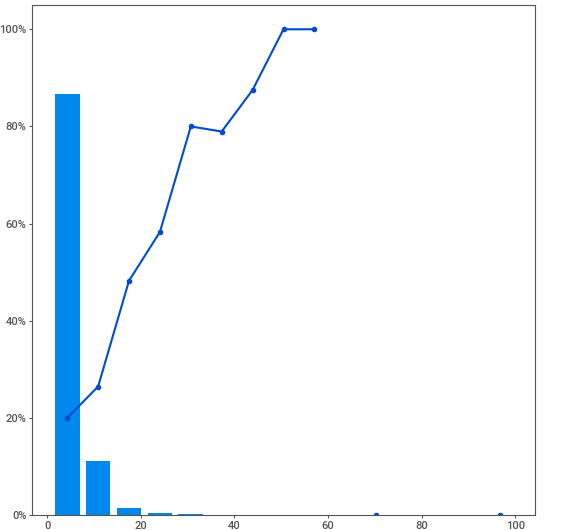
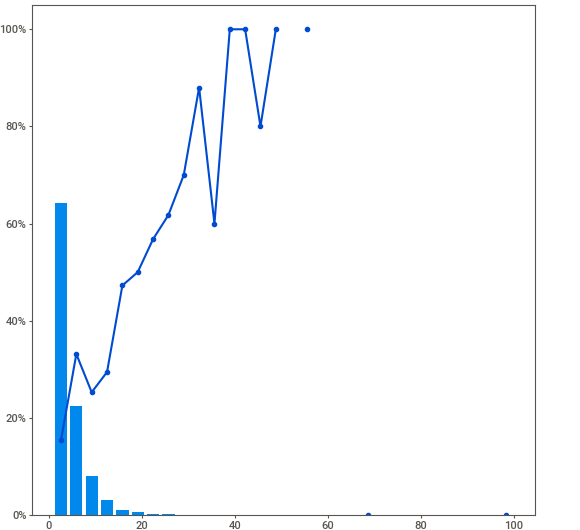
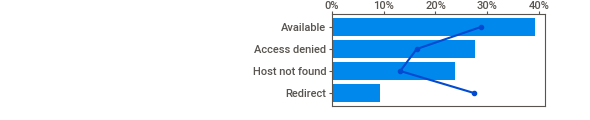
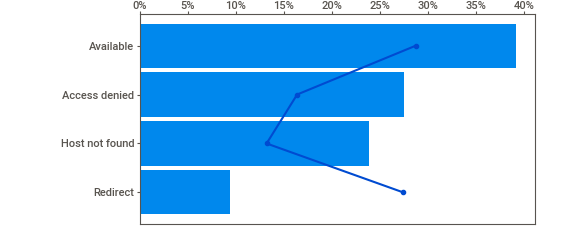
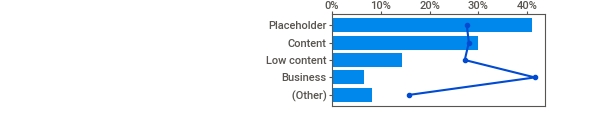
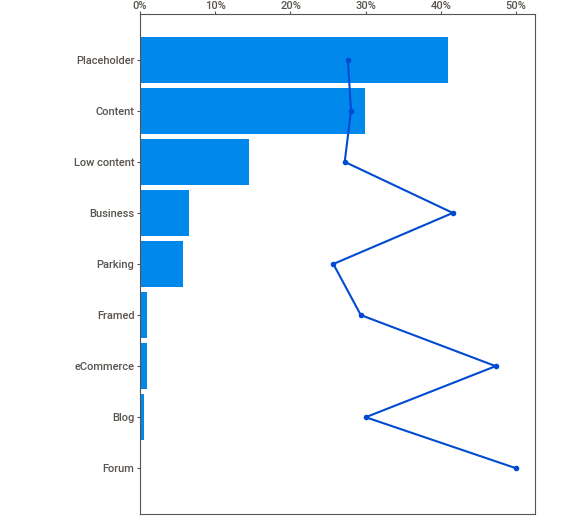
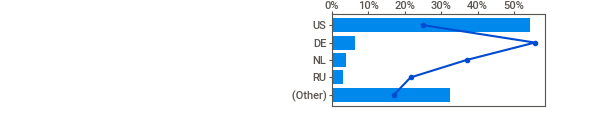
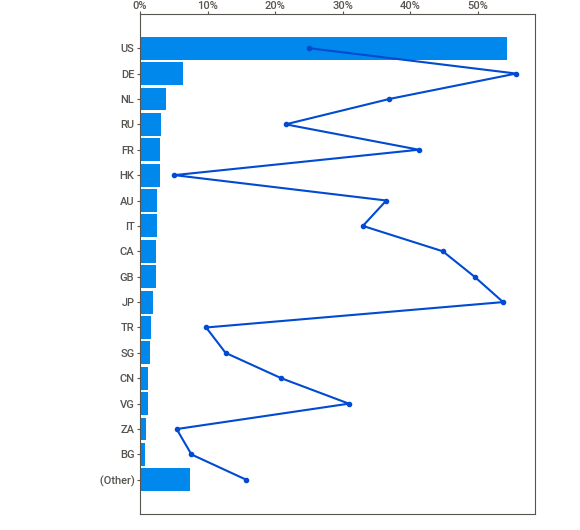
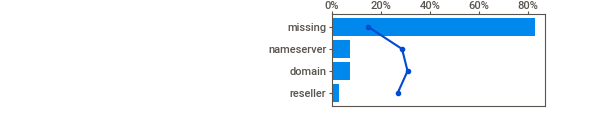
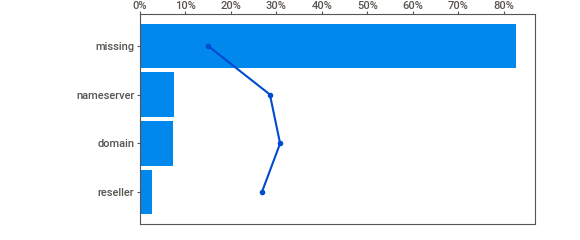
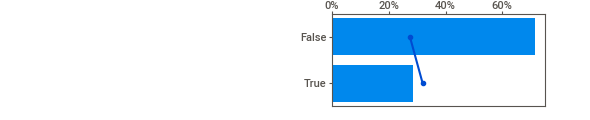
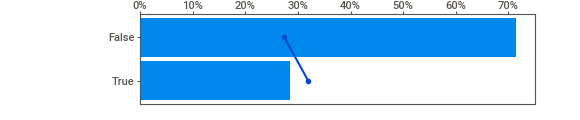
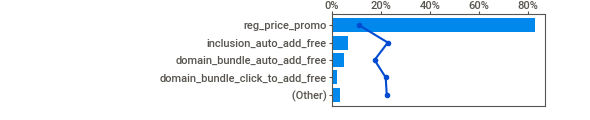
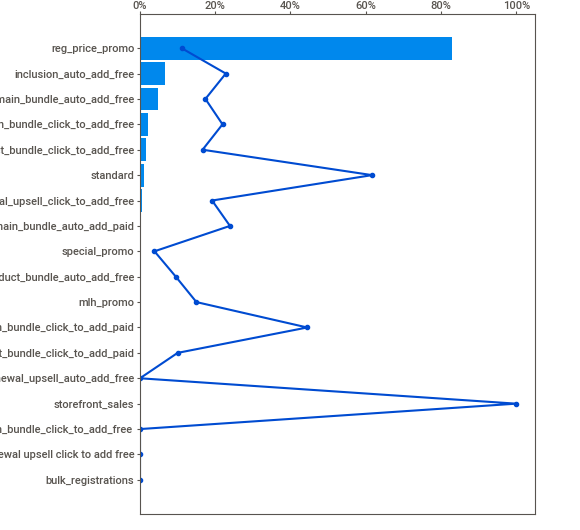
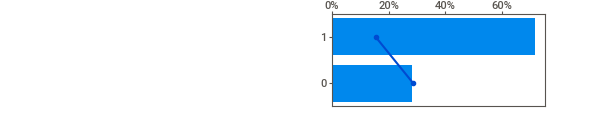
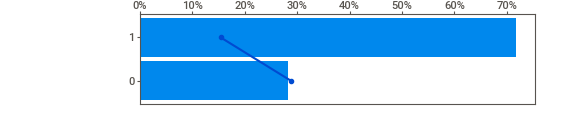
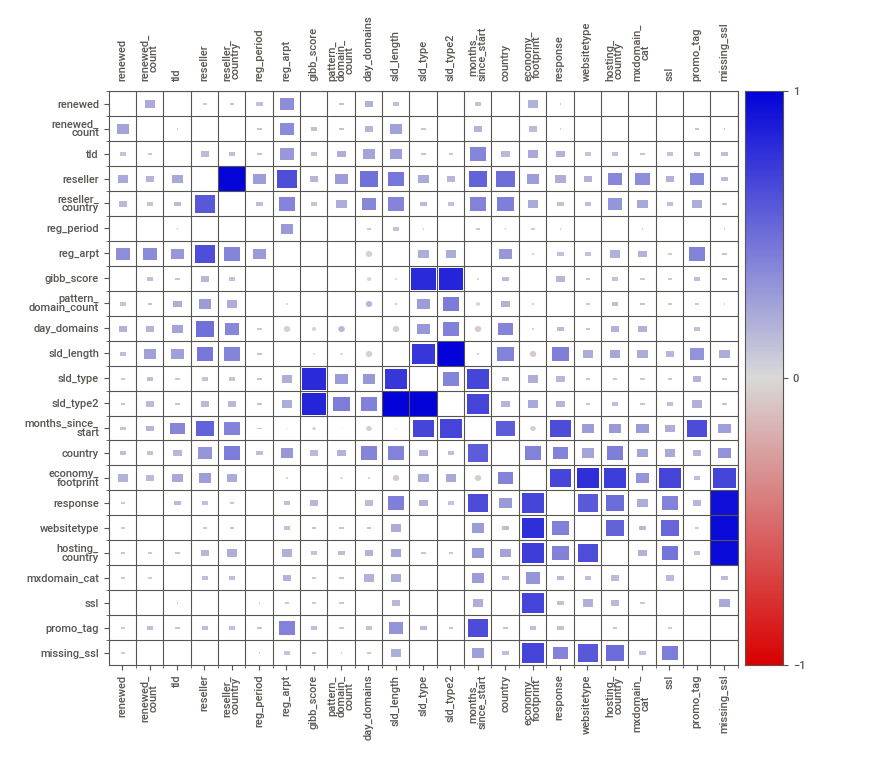
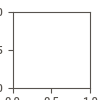

In [11]:
import sweetviz as sv
X["renewed"] = df["renewed"]
X["missing_ssl"] = X.ssl.isna().astype(int)
myrep = sv.analyze(X[X.expiry_date < "2022-01-01"].sample(100000), target_feat="renewed")
myrep.show_notebook()


                                             |          | [  0%]   00:00 -> (? left)


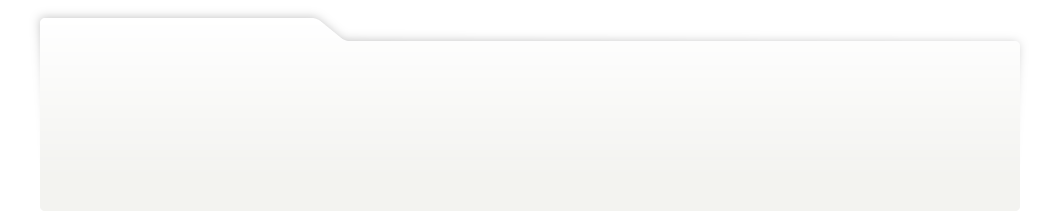
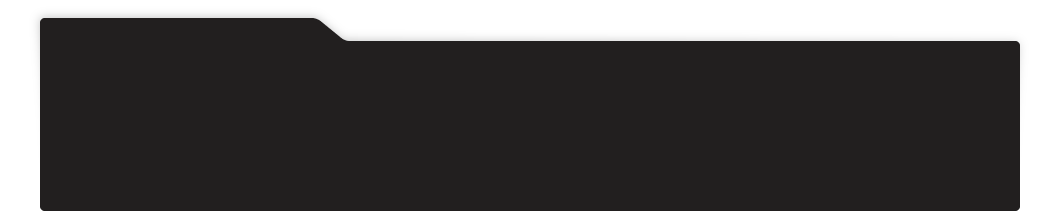
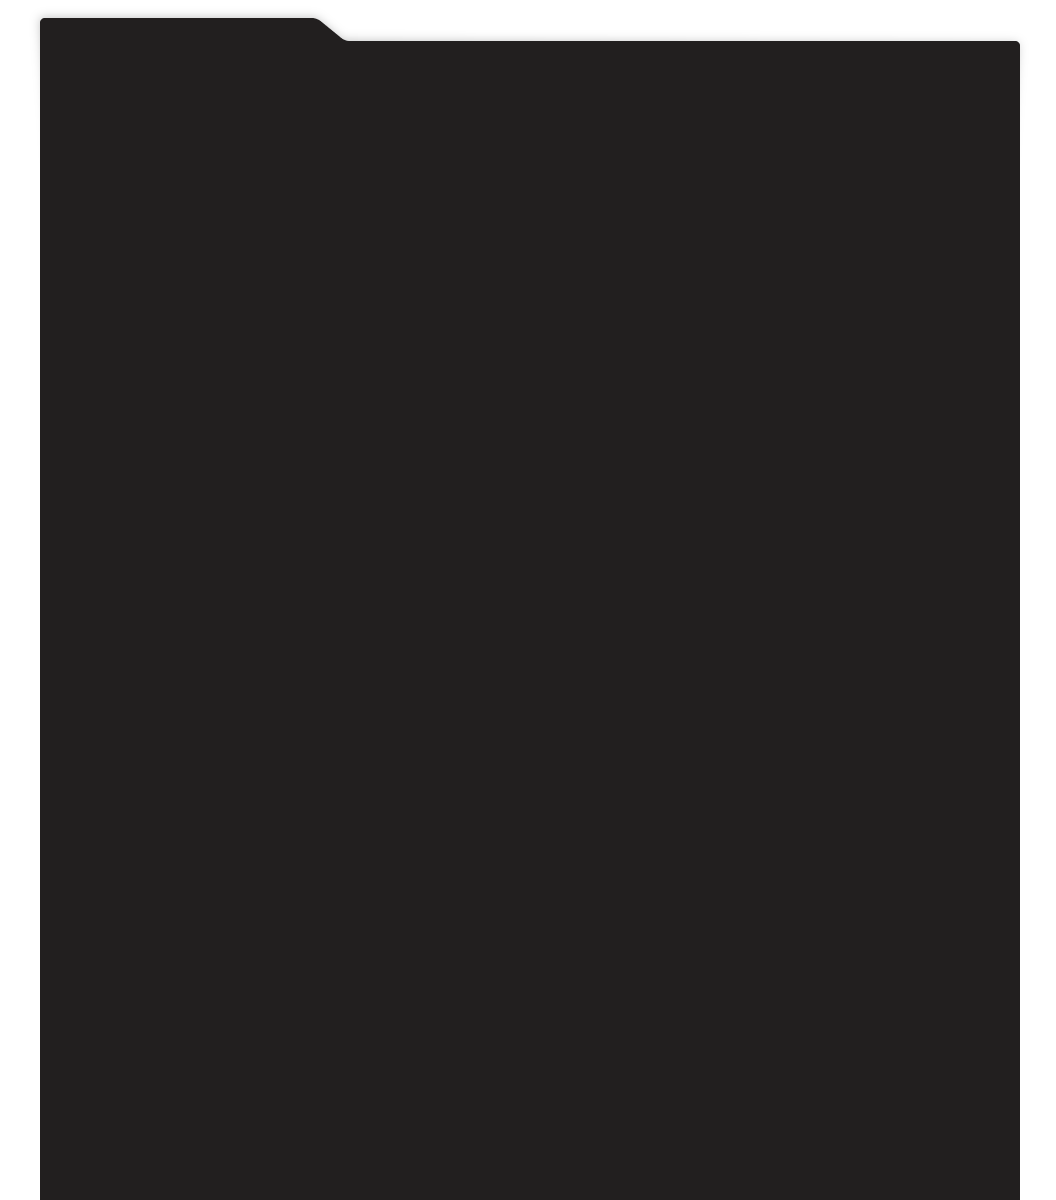
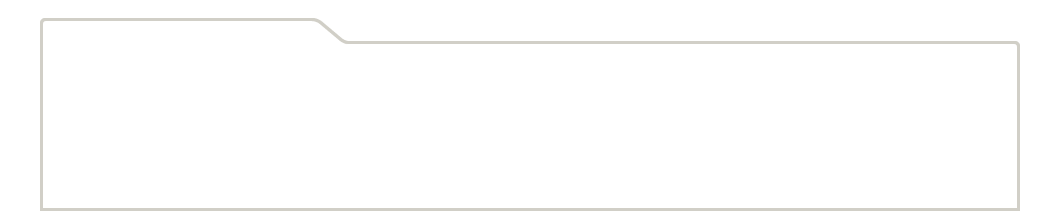
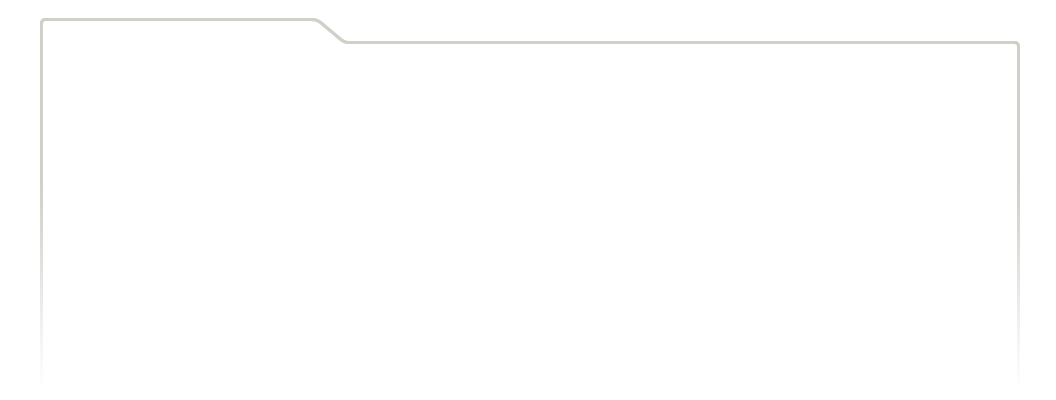
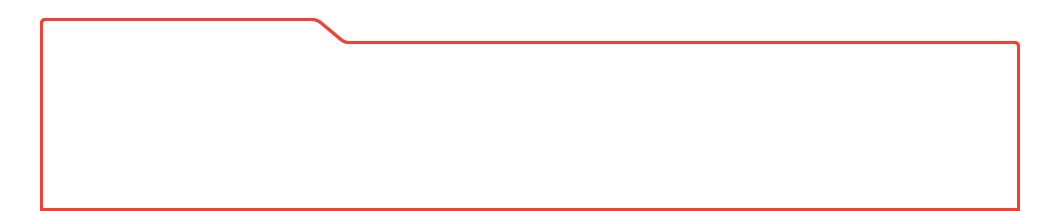
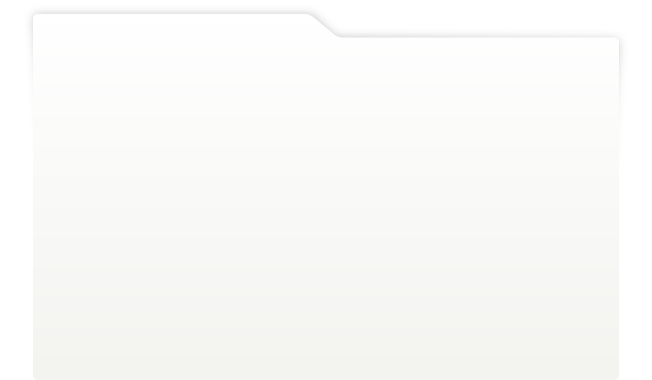
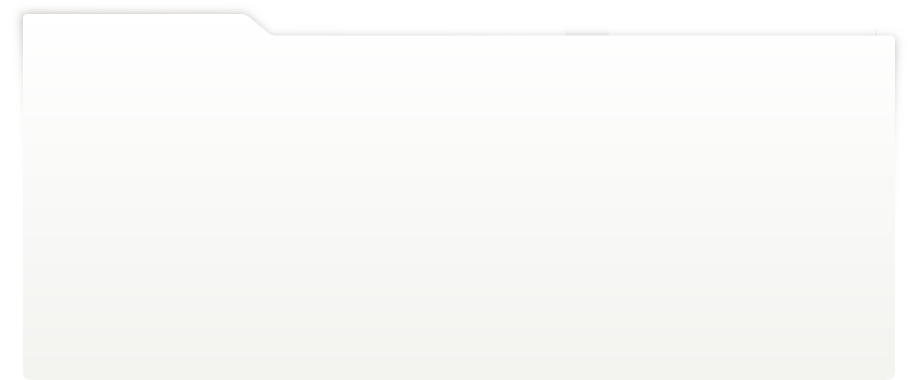
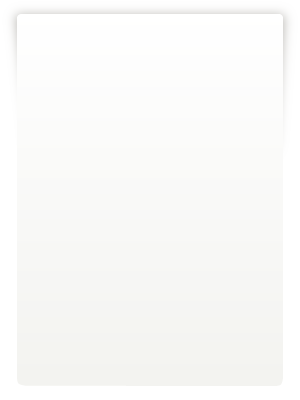
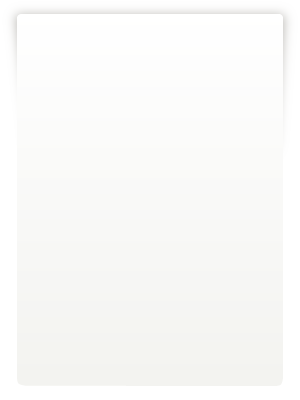
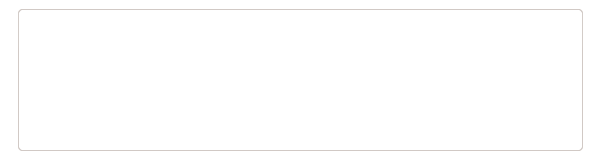
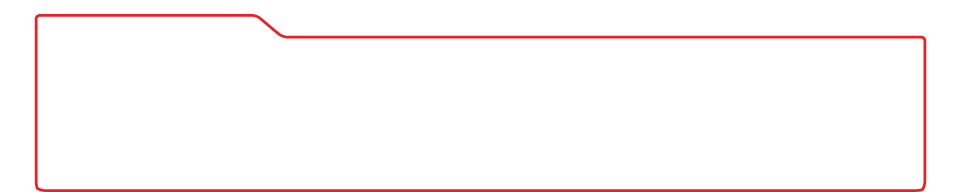
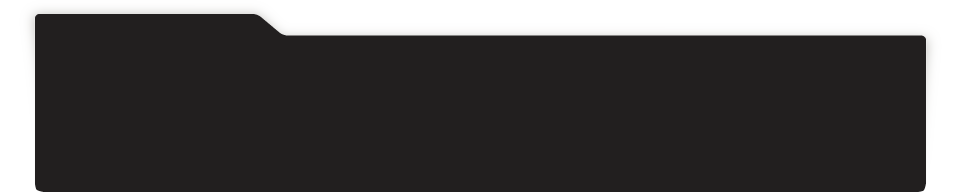
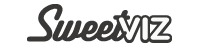
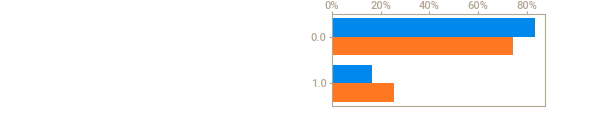
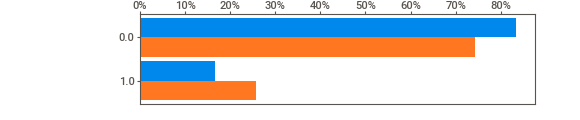
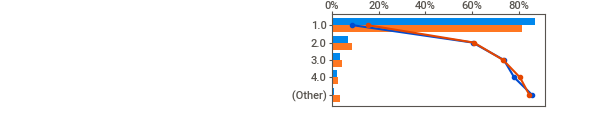
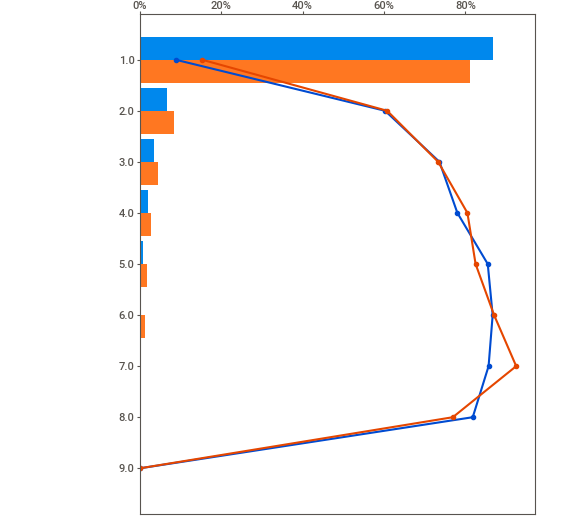
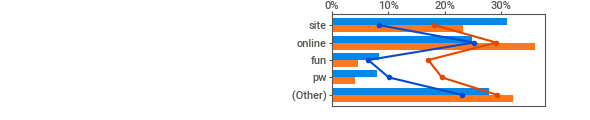
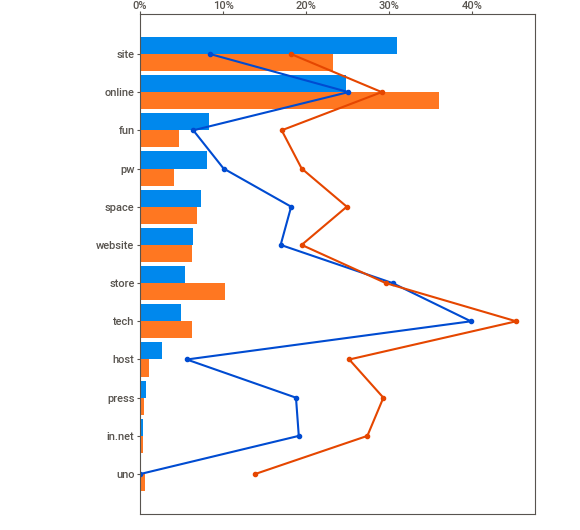
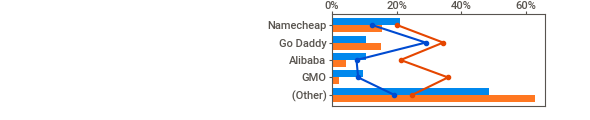
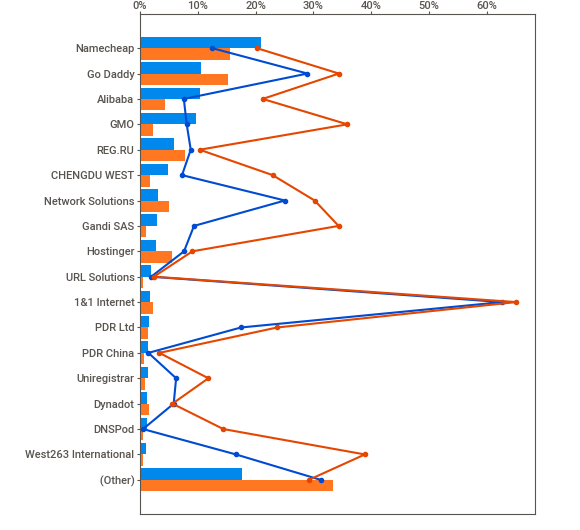
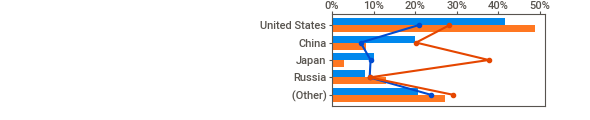
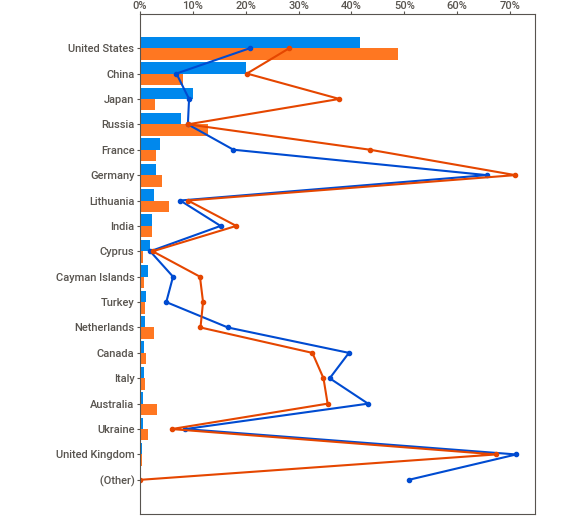
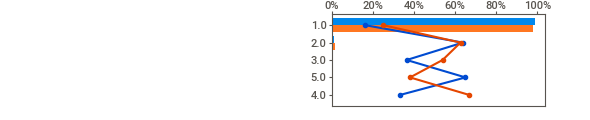
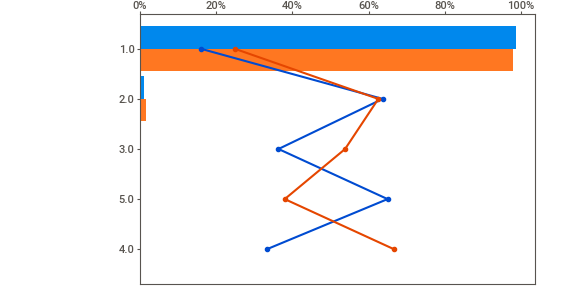
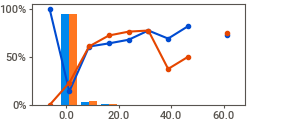
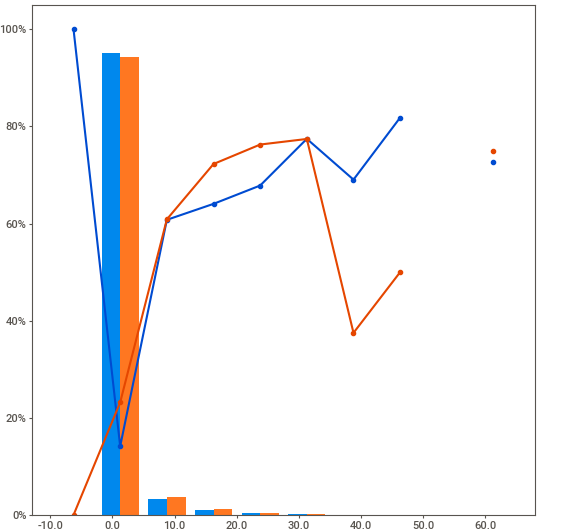
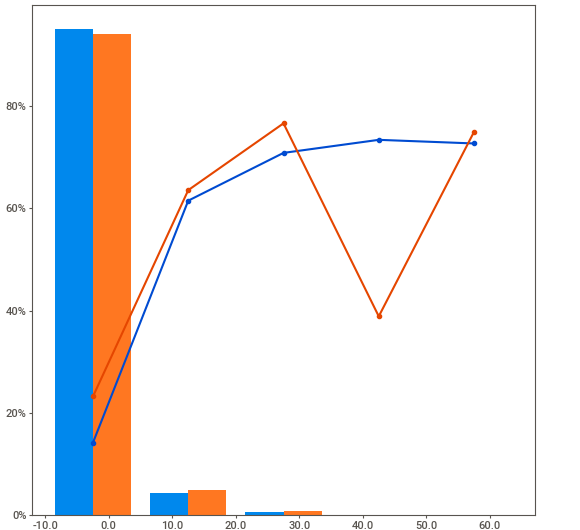
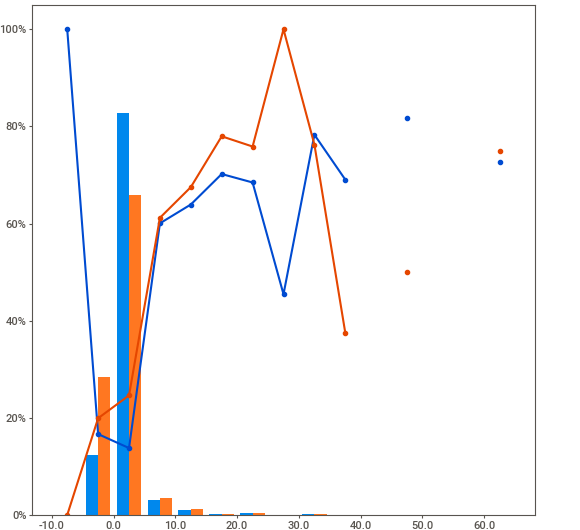
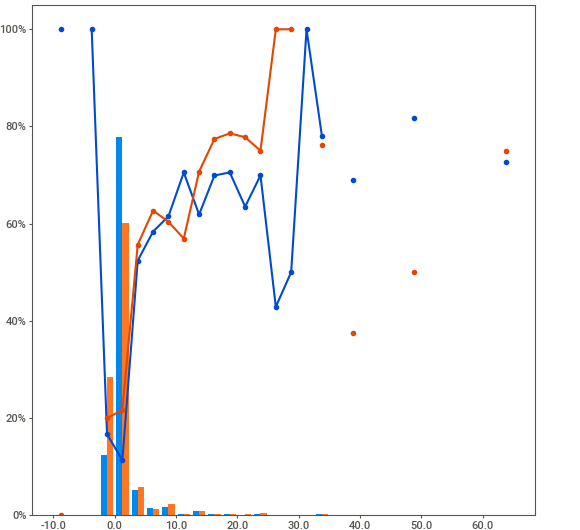
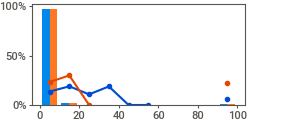
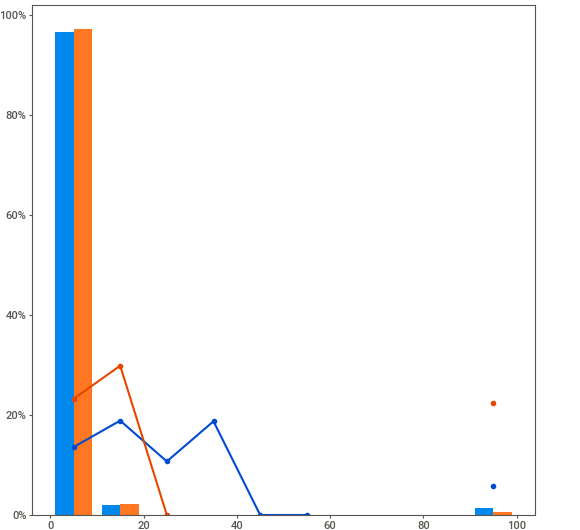
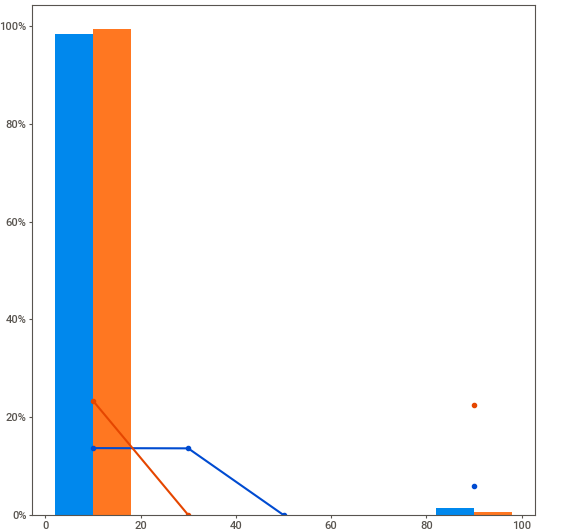
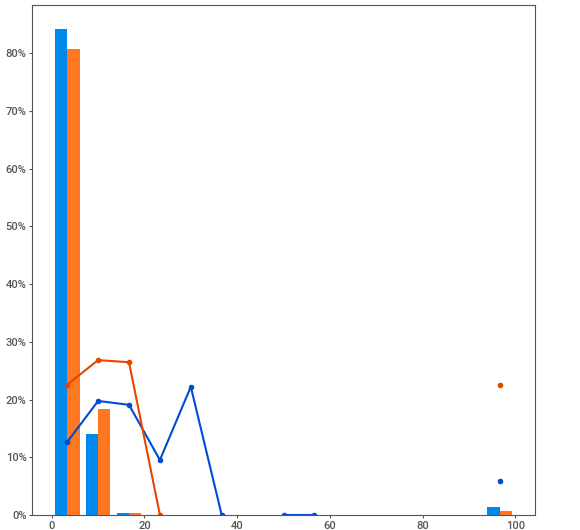
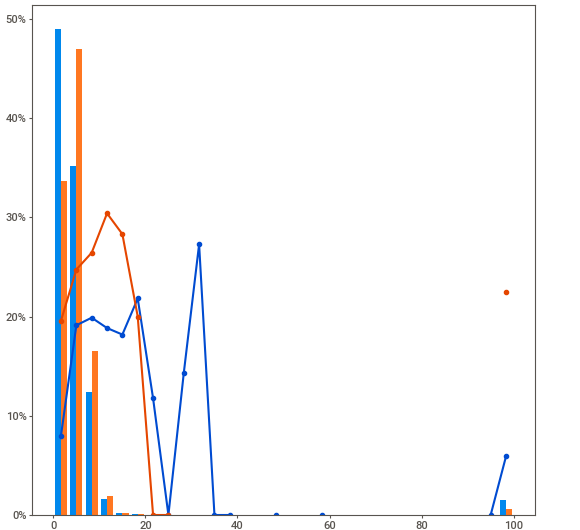
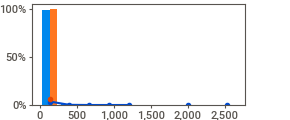
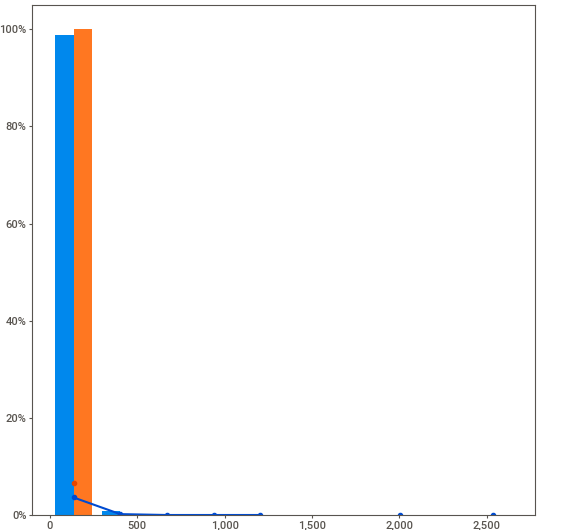
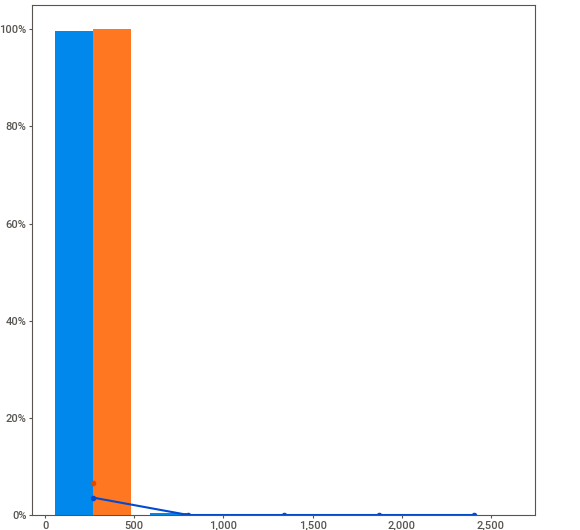
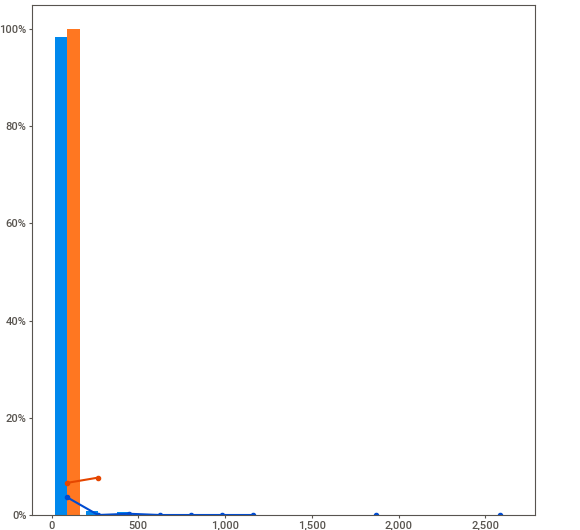
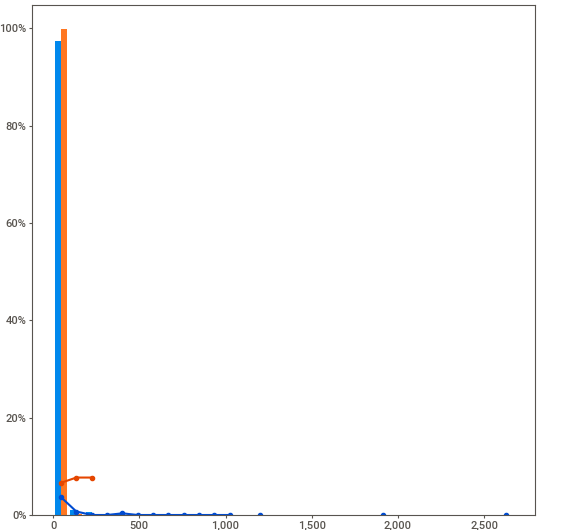
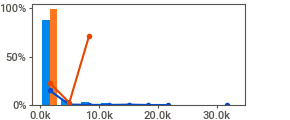
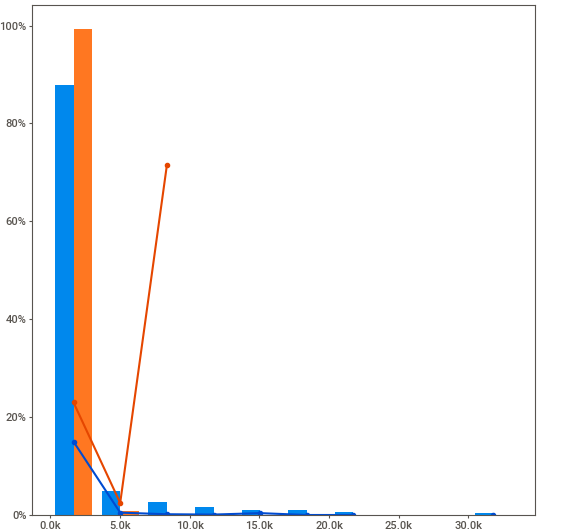
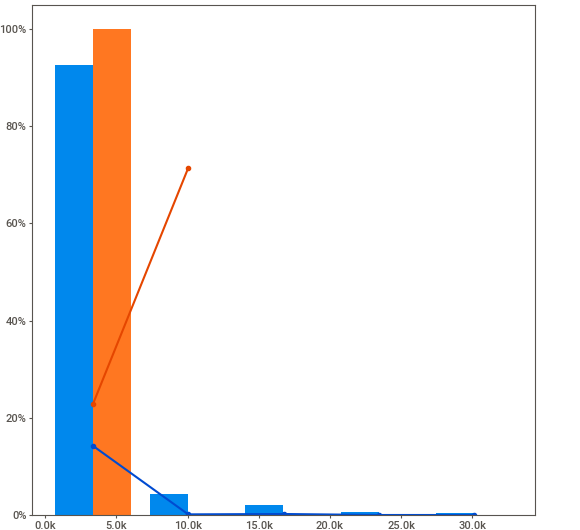
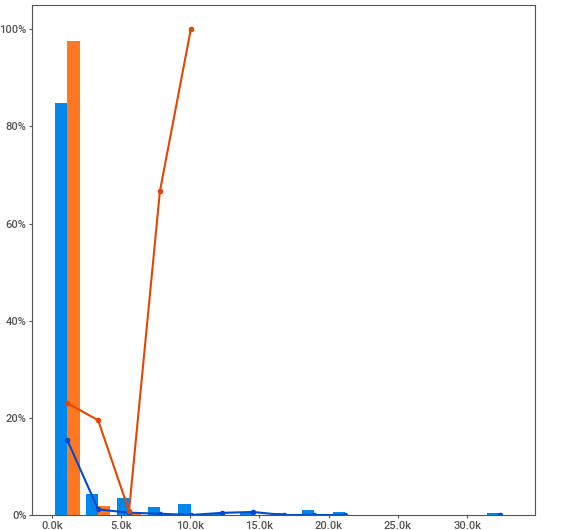
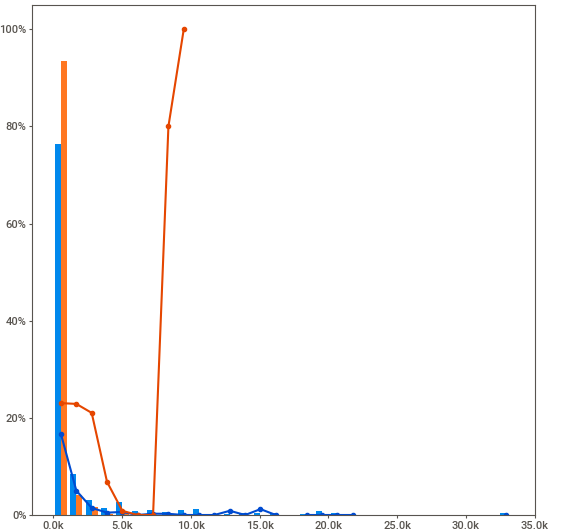
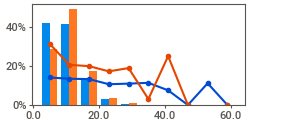
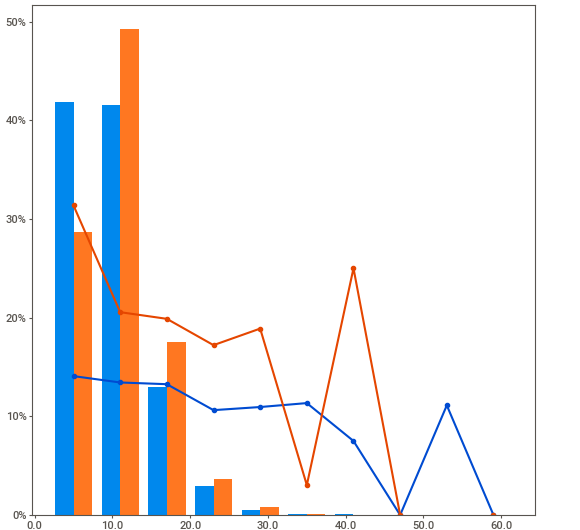
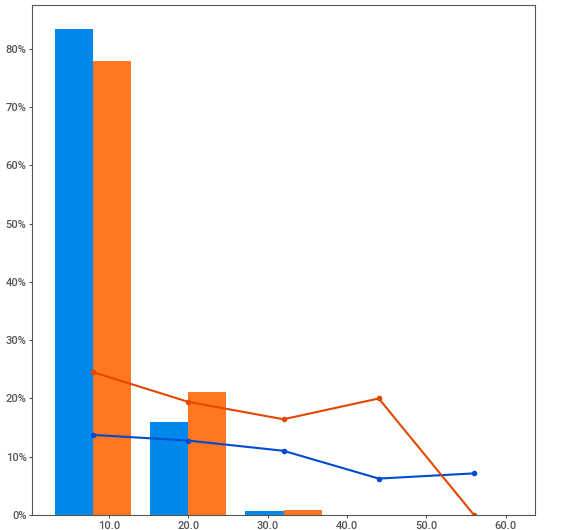
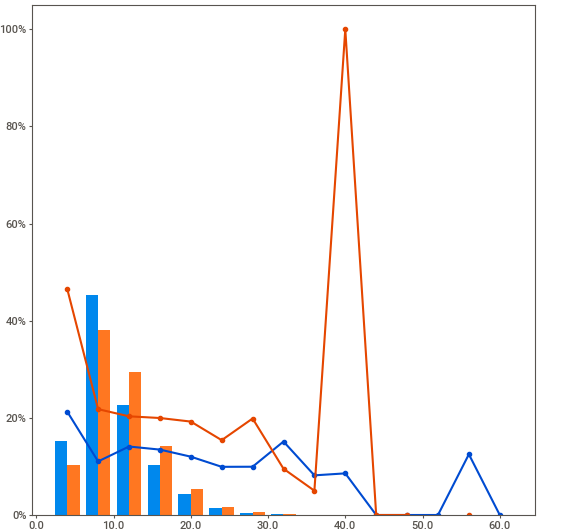
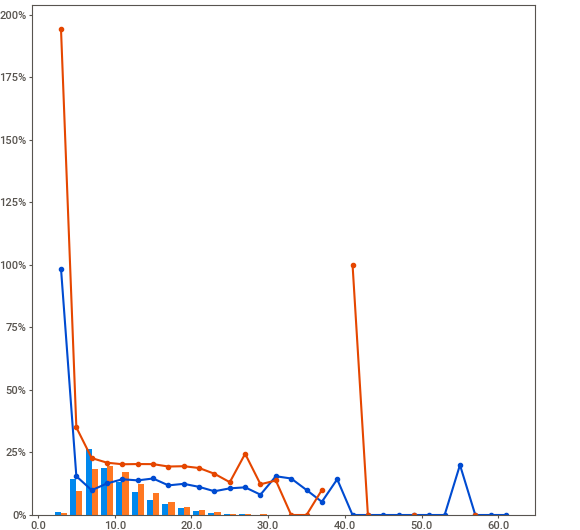
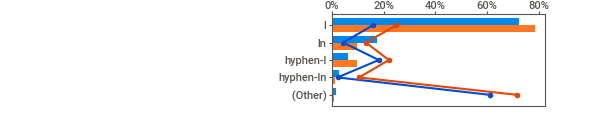
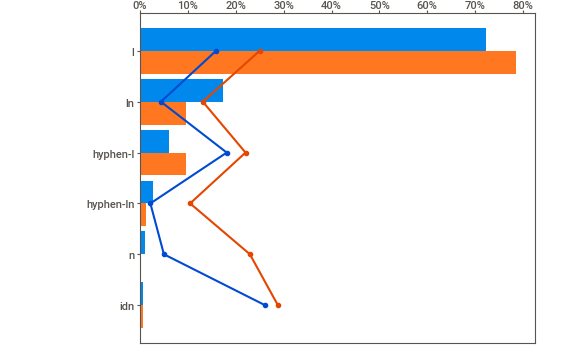
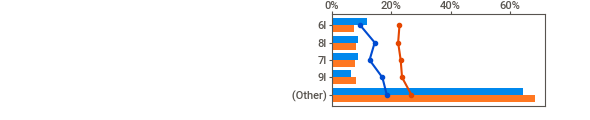
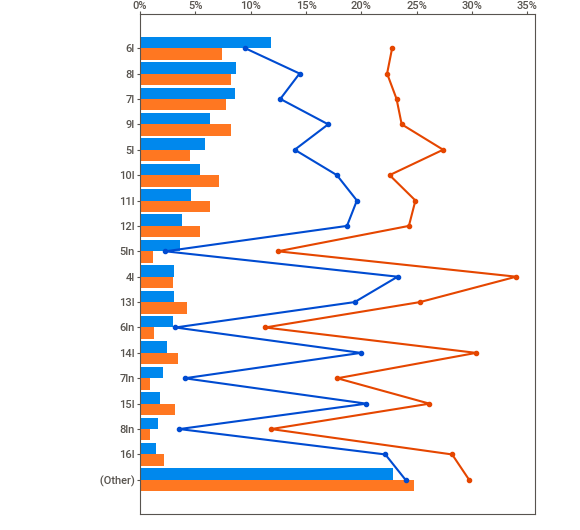
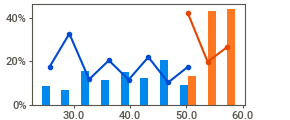
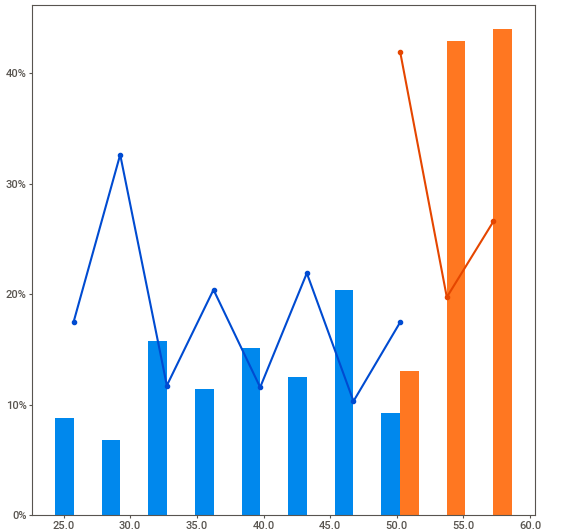
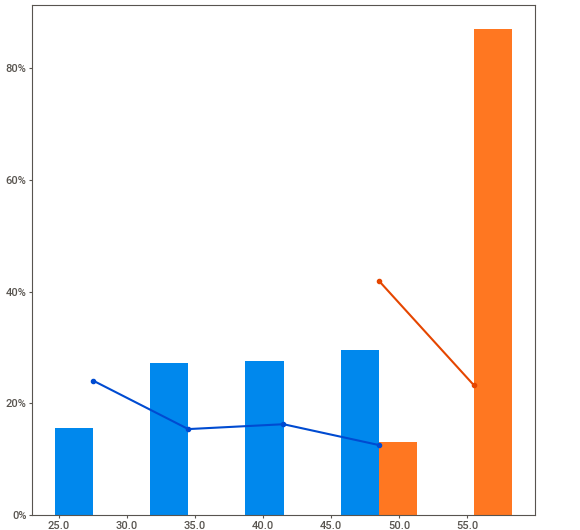
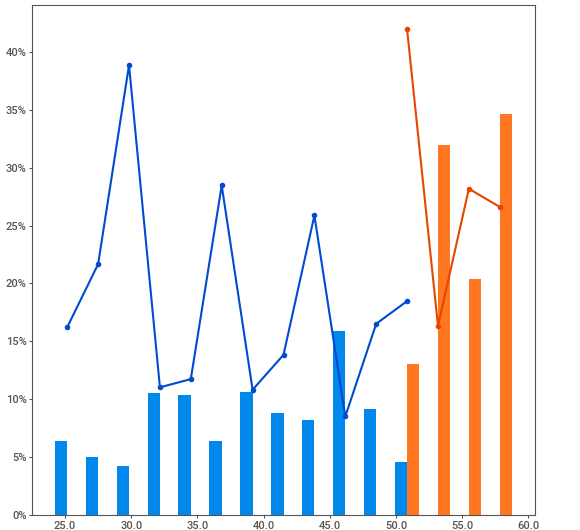
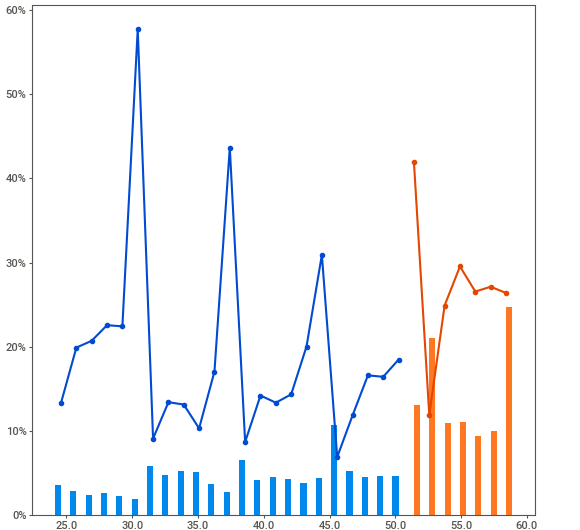
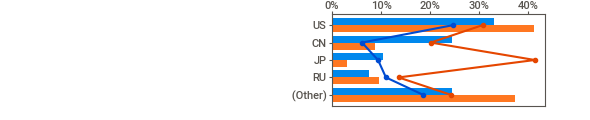
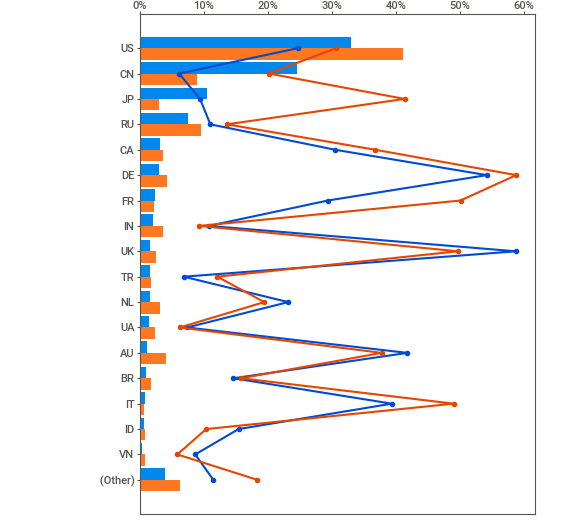
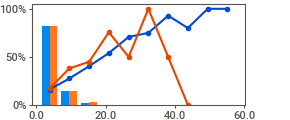
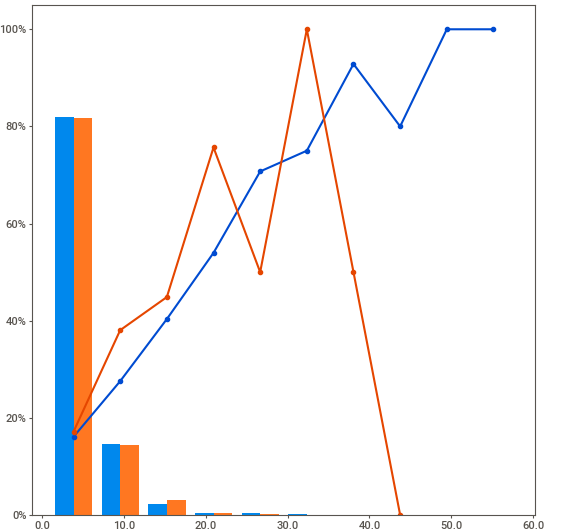
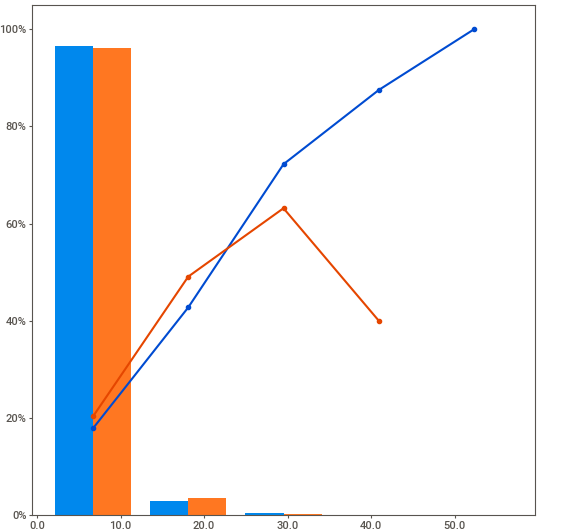
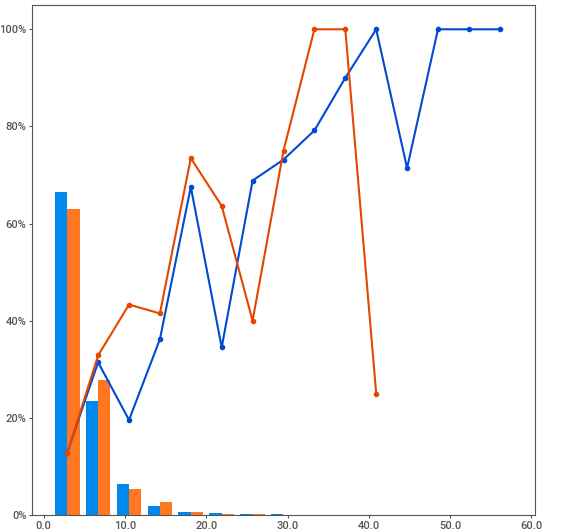
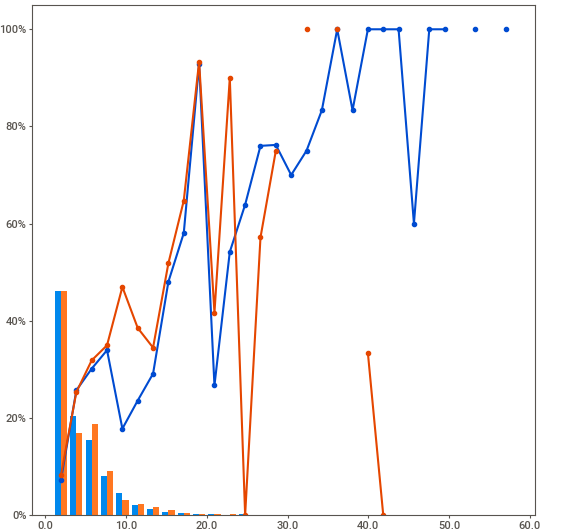
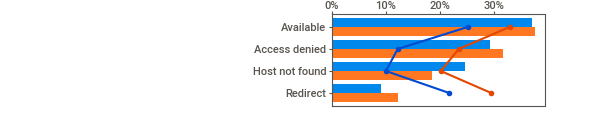
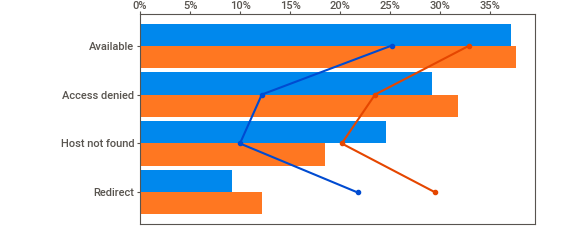
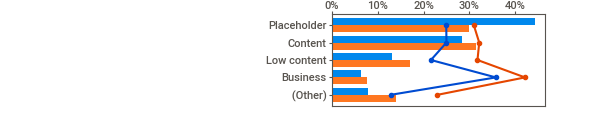
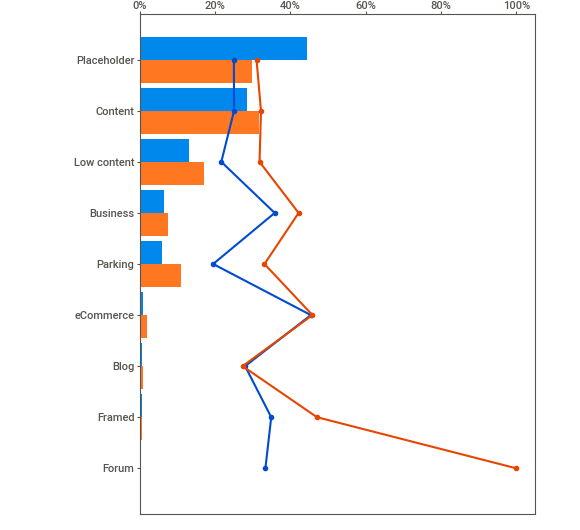
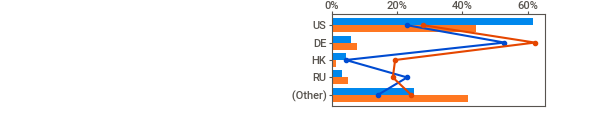
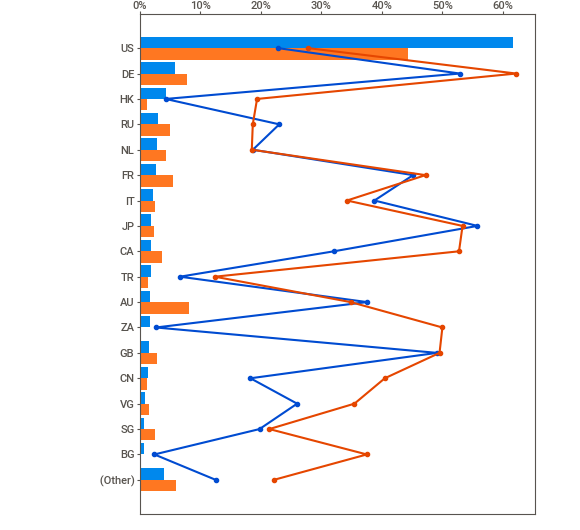
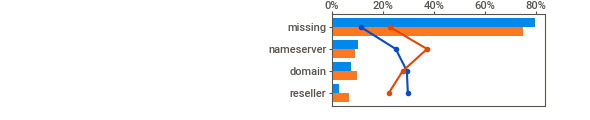
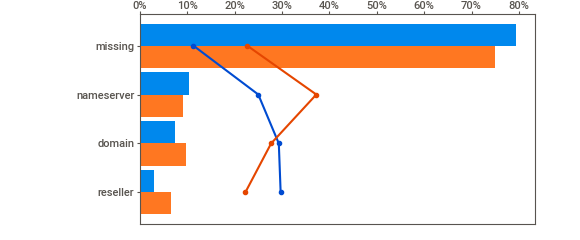
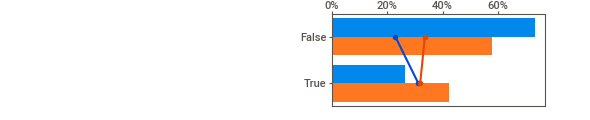
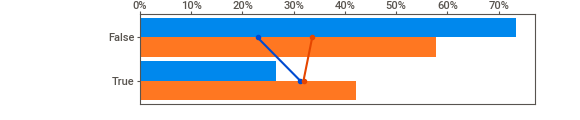
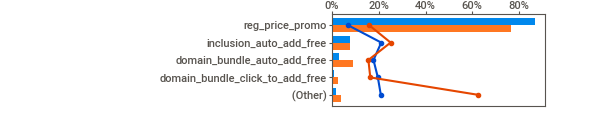
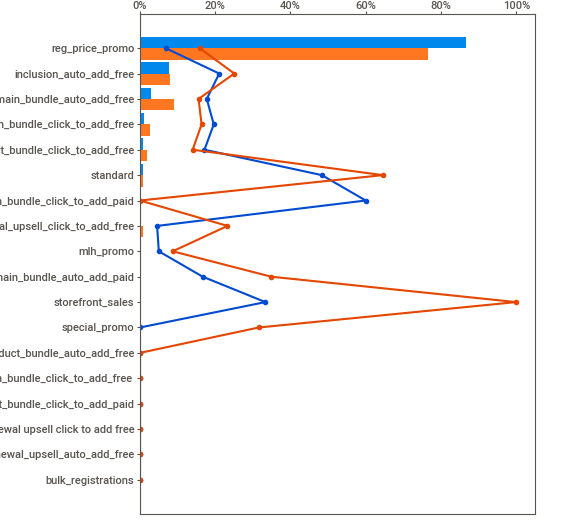
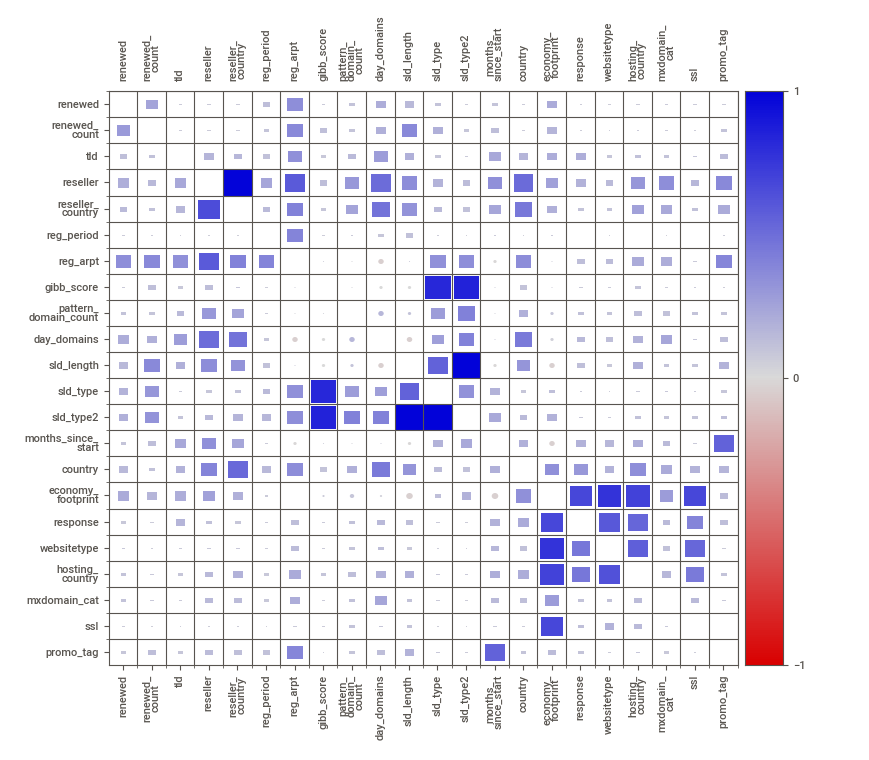
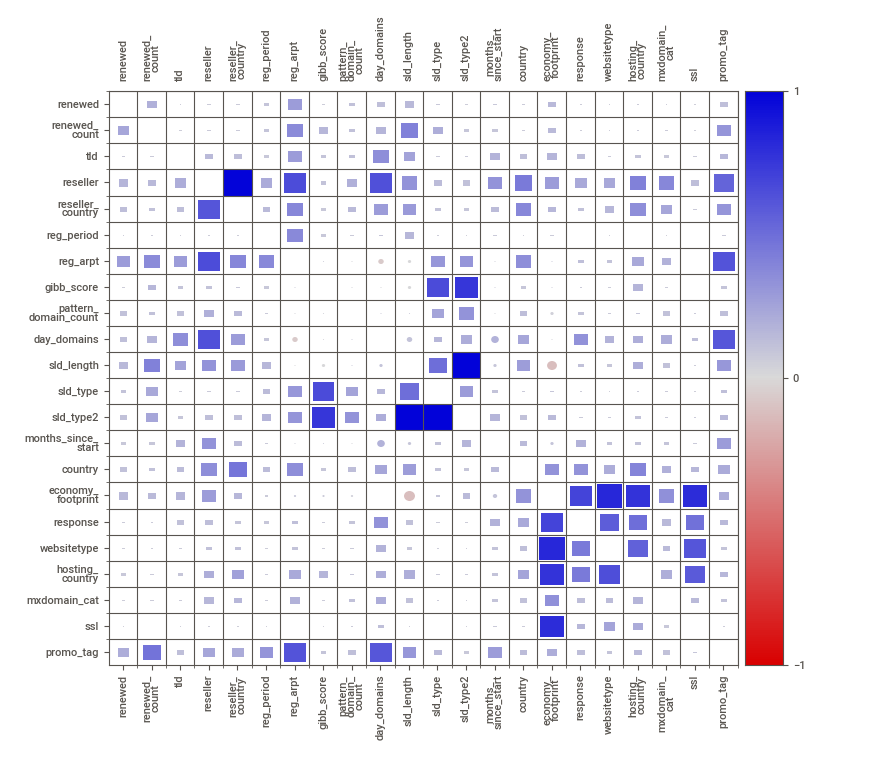

In [17]:
tmp = X_[(X_.expiry_date < "2022-01-01") & (X_.expiry_date >= "2019-01-01")].sample(100000)
myrep = sv.compare_intra(tmp, tmp.expiry_date < "2021-04-01", ["Train", "Test"], target_feat="renewed")
myrep.show_notebook()


## Investigating Feature Usefulness

In [21]:
non_dp_features

['renewed_count',
 'tld',
 'reseller',
 'reseller_country',
 'reg_period',
 'reg_arpt',
 'gibb_score',
 'pattern_domain_count',
 'day_domains',
 'sld_length',
 'sld_type',
 'sld_type2',
 'predictions_renewal_type',
 'months_since_start']

In [30]:
from sklearn.model_selection import train_test_split

time_split = True

non_dp_features = [
    'renewed_count', 'tld', 'reseller', 'reseller_country', 'reg_period',
    'reg_arpt', 'gibb_score', 'pattern_domain_count', 'day_domains', 'sld_length', 'sld_type',
    'predictions_renewal_type', 'months_since_start'
]
features = non_dp_features
X = df[features].copy()
X = convert_dtypes(X)

# train test parameters
end_train = "2021-04-01"
end_test = "2022-07-01"
train_months = 18
start_train = pd.to_datetime(end_train) - pd.DateOffset(months=train_months)

# split train and test
if time_split:
    train_mask = (df.expiry_date >= start_train) & (df.expiry_date < end_train)
    test_mask = (df.expiry_date >= end_train) & (df.expiry_date < end_test)
    X_train = X[train_mask].copy()
    y_train = df.loc[train_mask, "renewed"].copy()
    X_test = X[test_mask].copy()
    y_test = df.loc[test_mask, "renewed"].copy()
    preds_df = df[test_mask].copy()
else:
    mask = (df.expiry_date >= start_train) & (df.expiry_date < end_test)
    X_train, X_test, y_train, y_test = train_test_split(X[mask], df.loc[mask, "renewed"], test_size=0.33)


# Train model
mc = [1 if col == "renewed_count" else 0 for col in features]
clf = lgb.LGBMClassifier(n_jobs=-1, mc=mc, mc_method="advanced")
clf.fit(X_train, y_train)

LGBMClassifier(mc=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], mc_method='advanced')

## Train Model

In [5]:
from sklearn.inspection import permutation_importance

In [7]:
df.expiry_date.max()

Timestamp('2022-12-31 00:00:00')

Running feature importance


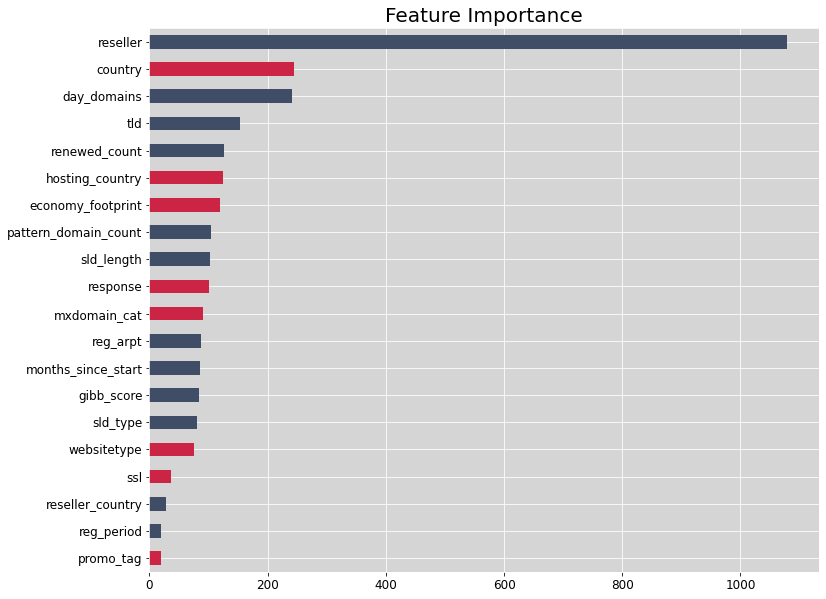

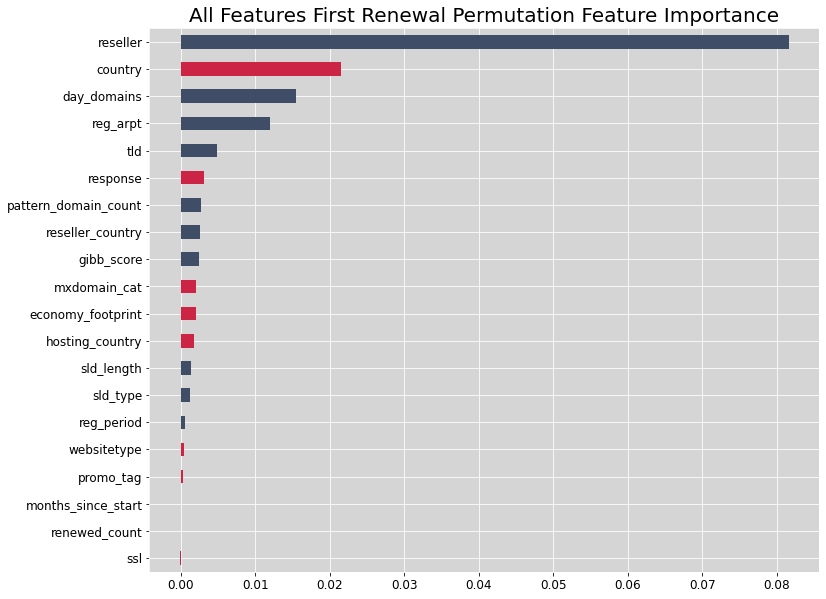

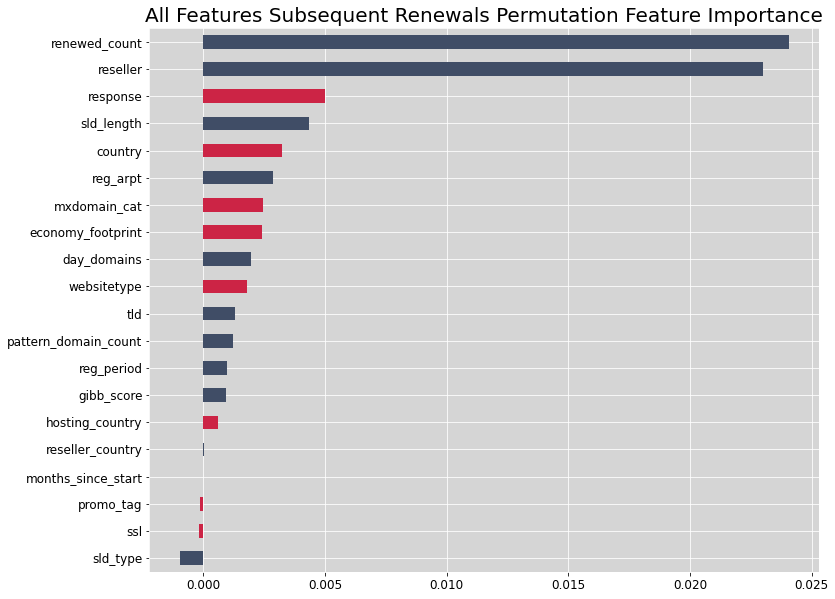

Running feature importance


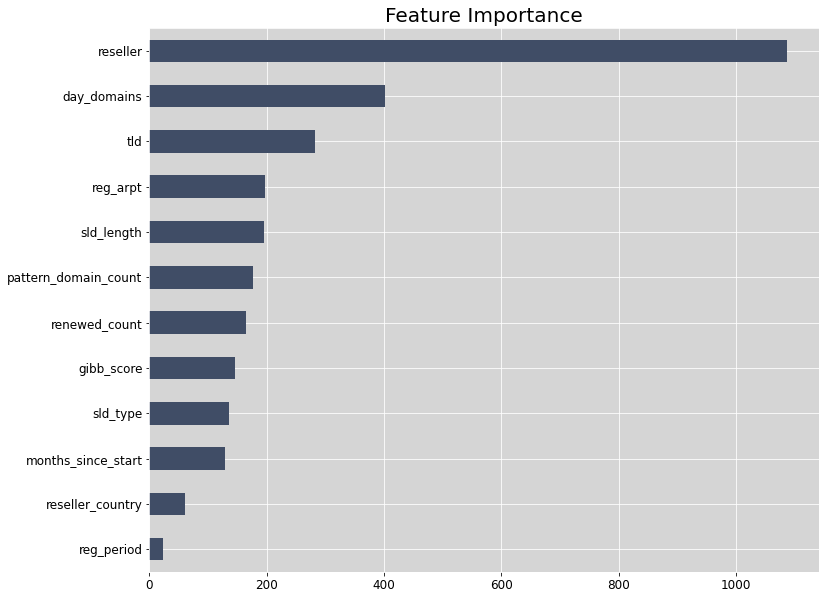

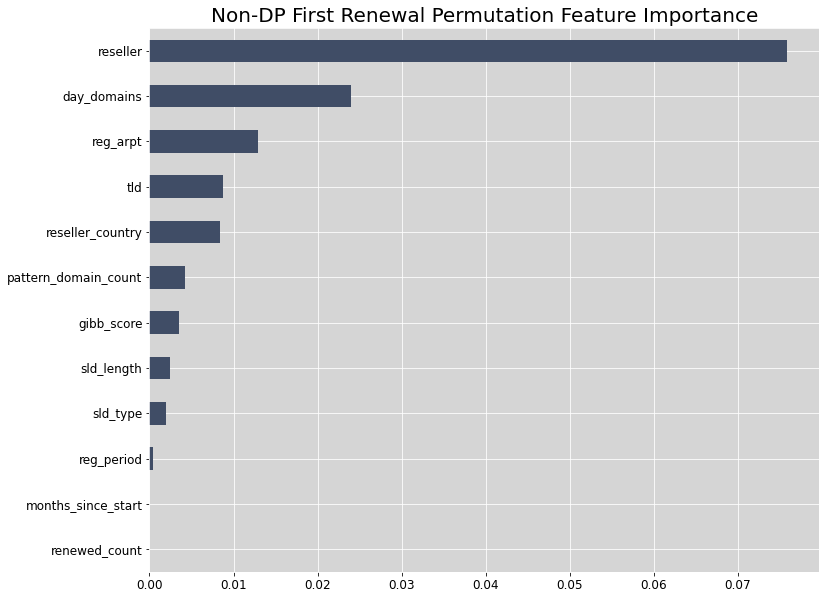

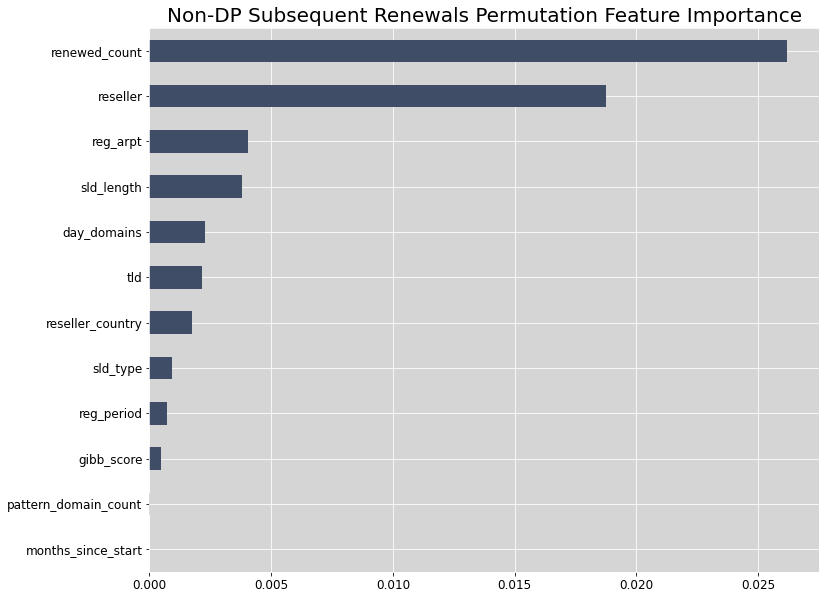

domain expiry_date   tld reseller  renewed_count renewal_status  \
0   upon13201.site  2022-01-05  site      GMO              1     Not Renewd   
25      pocke.tech  2022-02-25  tech      GMO              2     Not Renewd   
29     urrsvi.site  2021-05-14  site      GMO              1     Not Renewd   
78   office-m.tech  2022-04-07  tech      GMO              1        Renewed   
85     keitry.site  2022-06-04  site      GMO              2     Not Renewd   

    renewed feature_set     model  prediction        promo_tag    ssl  
0         0         all  lightgbm    0.136164  reg_price_promo    NaN  
25        0         all  lightgbm    0.681872  reg_price_promo  False  
29        0         all  lightgbm    0.102528  reg_price_promo    NaN  
78        1         all  lightgbm    0.741107              NaN    NaN  
85        0         all  lightgbm    0.787337  reg_price_promo   True

In [8]:
# Define features
non_dp_features = [
    'renewed_count', 'tld', 'reseller', 'reseller_country', 'reg_period',
    'reg_arpt', 'gibb_score', 'pattern_domain_count', 'day_domains', 'sld_length', 'sld_type',
    'months_since_start'
]
dp_features = ["country", "economy_footprint", "response", "websitetype", "hosting_country", 'mxdomain_cat', "ssl", "promo_tag"]
verbose = 1

# Columns to save to bq
rel_cols = ["domain", "expiry_date", "tld", "reseller", "renewed_count", "renewal_status", "renewed", "feature_set", "model", "prediction", 'promo_tag', 'ssl']
pred_df_list = []
for dp in [True, False]:
    features = list(non_dp_features)
    if dp:
        features += dp_features

    # Select features and fix data types
    X = df[features].copy()
    X = convert_dtypes(X)

    # train test parameters
    end_train = "2021-04-01"
    end_test = "2023-07-01"
    train_months = 18
    start_train = pd.to_datetime(end_train) - pd.DateOffset(months=train_months)

    # split train and test
    train_mask = (df.expiry_date >= start_train) & (df.expiry_date < end_train)
    test_mask = (df.expiry_date >= end_train) & (df.expiry_date < end_test)
    X_train = X[train_mask].copy()
    y_train = df.loc[train_mask, "renewed"].copy()
    X_test = X[test_mask].copy()
    y_test = df.loc[test_mask, "renewed"].copy()
    preds_df = df[test_mask].copy()

    # Train model
    mc = [1 if col == "renewed_count" else 0 for col in features]
    clf = lgb.LGBMClassifier(n_jobs=-1, mc=mc, mc_method="advanced")
    clf.fit(X_train, y_train)

    # Plot importances
    if verbose > 0:
        print("Running feature importance")
        # Normal
        fig, ax = plt.subplots(figsize=(12,10))
        ax.set_title("Feature Importance")
        fi = pd.Series(clf.feature_importances_, index=features)
        fi = fi.sort_values()
        colors = ["#CC2445" if col in dp_features else "#404D66" for col in fi.index]
        # fi.sort_values().iloc[-15:].plot.barh()
        fi.plot.barh(color=colors)
        plt.show()

        # Permutation
        mask = df.loc[test_mask, "expiry_date"] < "2022-01-01"
        for rc in ["First Renewal", "Subsequent Renewals"]:
            if rc == "First Renewal":
                curr_mask = mask & (X_test.renewed_count == 1)
            elif rc == "Subsequent Renewals":
                curr_mask = mask & (X_test.renewed_count > 1)
            s = np.random.choice(X_test[curr_mask].index, size=100000)
            res = permutation_importance(clf, X_test.loc[s, :], y_test.loc[s], n_repeats=3, n_jobs=-1, scoring="neg_log_loss")
            fi = pd.Series(res.importances_mean, index=features)
            fig, ax = plt.subplots(figsize=(12,10))
            dt = ["Non-DP", "All Features"][dp]
            ax.set_title(f"{dt} {rc} Permutation Feature Importance")
            fi = fi.sort_values()
            colors = ["#CC2445" if col in dp_features else "#404D66" for col in fi.index]
            # fi.sort_values().iloc[-15:].plot.barh()
            fi.plot.barh(color=colors)
            plt.show()
        
        

    # Make and save predictions
    preds_df["prediction"] = clf.predict_proba(X_test)[:, 1]
    preds_df["feature_set"] = ["non_dp", "all"][dp]
    preds_df["model"] = "lightgbm"

    pred_df_list.append(preds_df[rel_cols])

all_preds = pd.concat(pred_df_list)
all_preds.head()

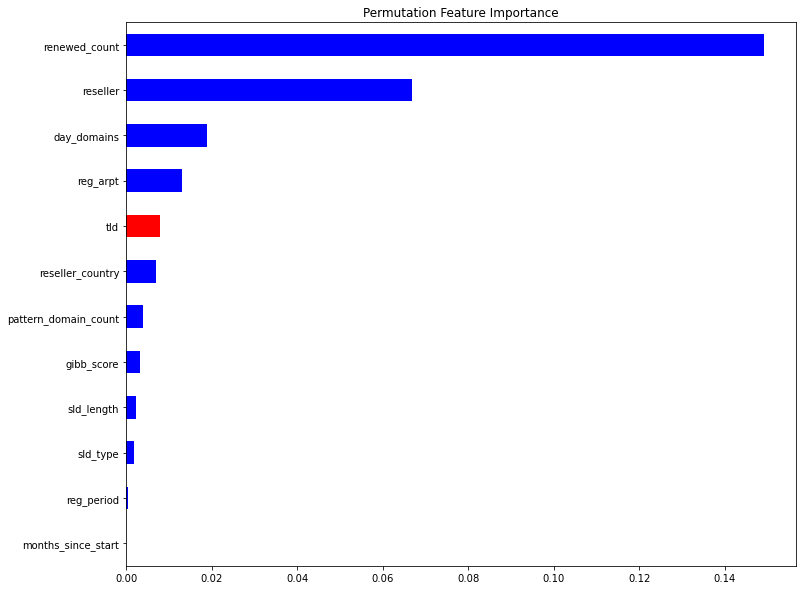

In [11]:
# s = np.random.choice(X_test[df.loc[test_mask, "expiry_date"] < "2022-01-01"].index, size=100000)
# res = permutation_importance(clf, X_test.loc[s, :], y_test.loc[s], n_repeats=3, n_jobs=-1, scoring="neg_log_loss")
fi = pd.Series(res.importances_mean, index=features)
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title("Permutation Feature Importance")
# fi.sort_values().iloc[-15:].plot.barh()
fi = fi.sort_values()
c = ["red" if col == "tld" else "blue" for col in fi.index]
fi.plot.barh(color=c)
plt.show()

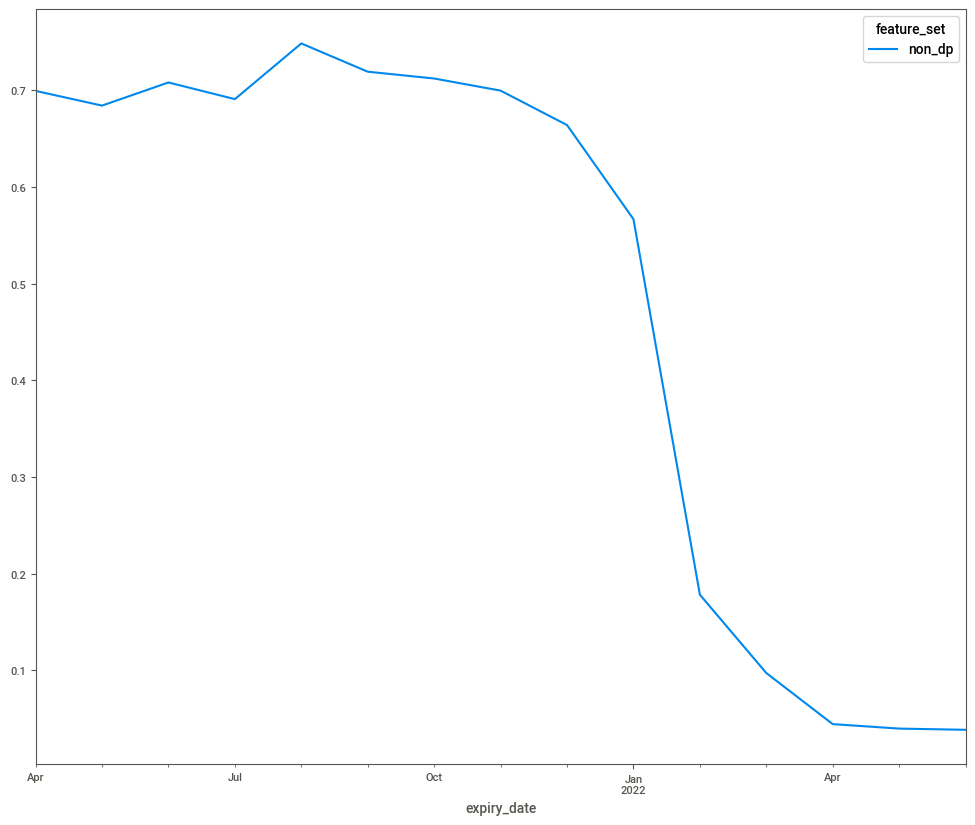

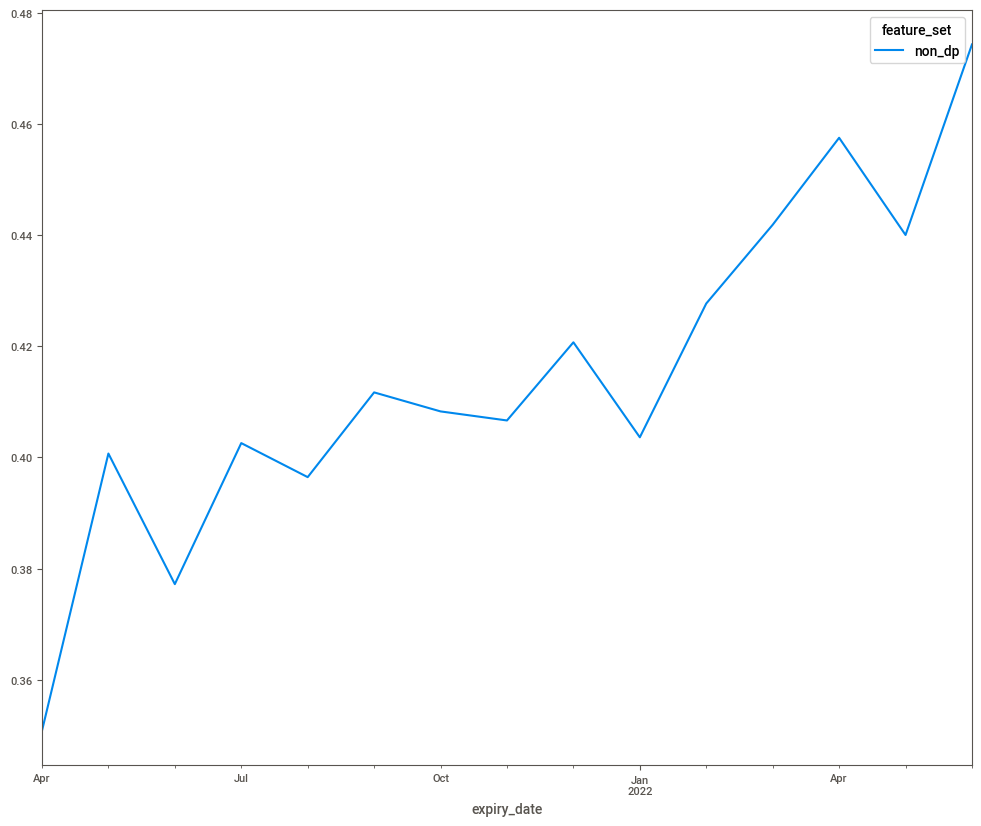

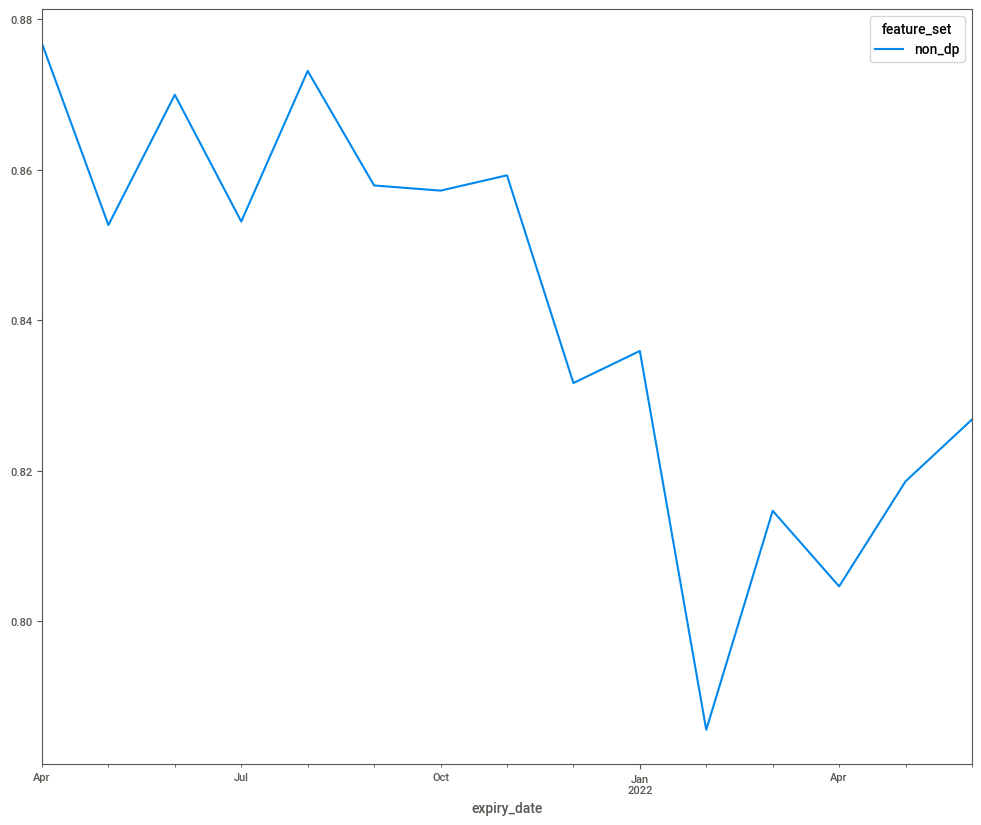

In [16]:
# Validation
from sklearn.metrics import average_precision_score, log_loss, roc_auc_score

mets = [average_precision_score, log_loss, roc_auc_score]
for met in mets:
    f = lambda x: met(x.renewed, x.prediction)
    g = all_preds.groupby([pd.Grouper(key="expiry_date", freq="MS"), "feature_set"]).apply(f)
    piv = g.unstack()
    piv.plot()
    plt.show()

## Investigating Accuracy Over Time by Reseller 

Training 2020-07-01


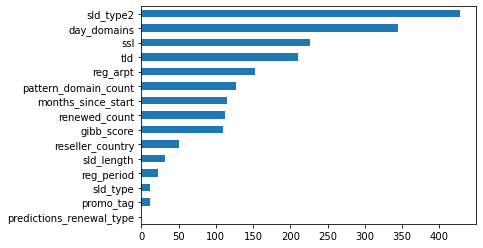

Training 2020-10-01


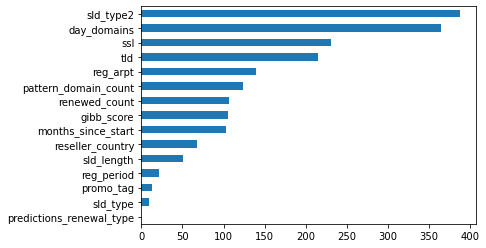

Training 2021-01-01


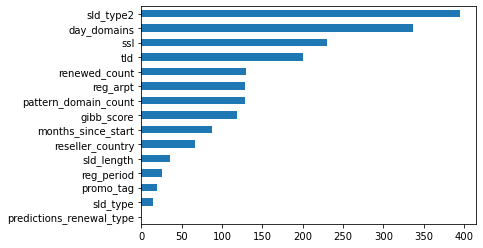

Training 2021-04-01


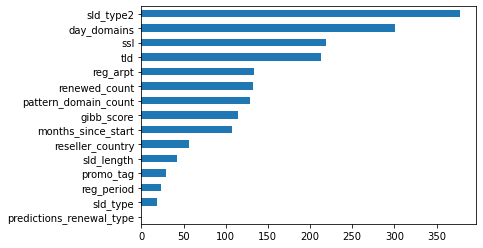

Training 2021-07-01


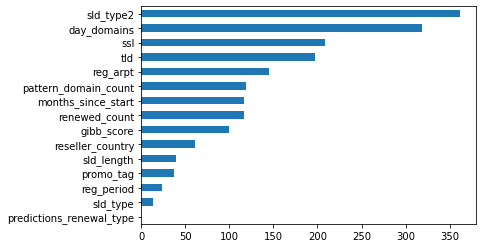

Training 2021-10-01


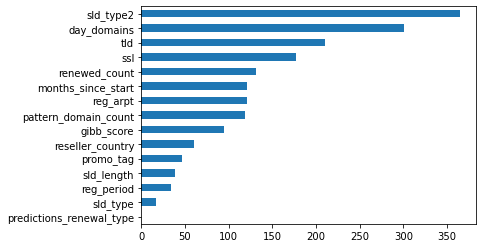

Training 2022-01-01


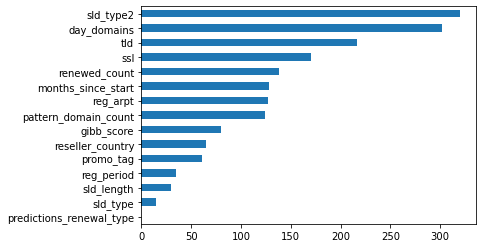

Training 2022-04-01


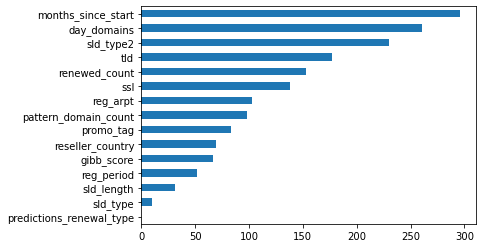

Training 2022-07-01


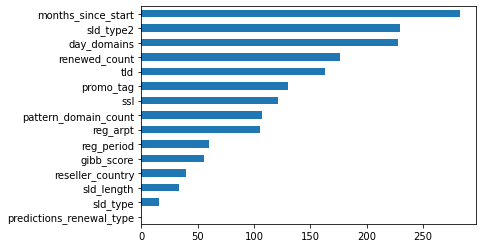

domain expiry_date     tld reseller  renewed_count renewal_status  \
5   a9ctlf1v.site  2020-09-17    site      GMO              1     Not Renewd   
19  ugoqgozi.site  2020-09-04    site      GMO              1     Not Renewd   
20     s0s.online  2020-07-14  online      GMO              1     Not Renewd   
22   bn6uuzx.site  2020-09-25    site      GMO              1     Not Renewd   
26   bwhsjdm.site  2020-07-17    site      GMO              1     Not Renewd   

    renewed feature_set     model  prediction  
5         0      non_dp  lightgbm    0.008253  
19        0      non_dp  lightgbm    0.001056  
20        0      non_dp  lightgbm    0.269704  
22        0      non_dp  lightgbm    0.000472  
26        0      non_dp  lightgbm    0.000896

In [9]:
# Define features
non_dp_features = [
    'renewed_count', 'promo_tag', 'tld', 'reseller', 'reseller_country', 'reg_period',
    'reg_arpt', 'gibb_score', 'pattern_domain_count', 'day_domains', 'sld_length', 'sld_type',
    'sld_type2', 'predictions_renewal_type', 'ssl', 'months_since_start'
]
end_trains = [
    "2020-07-01", "2020-10-01", "2021-01-01", "2021-04-01", "2021-07-01",
    "2021-10-01", "2022-01-01", "2022-04-01", "2022-07-01",
]
verbose = 1

# Select features and fix data types
features = list(non_dp_features)
X = df[features].copy()
X = convert_dtypes(X)

# Columns to save to bq
rel_cols = ["domain", "expiry_date", "tld", "reseller", "renewed_count", "renewal_status", "renewed", "feature_set", "model", "prediction"]
pred_df_list = []
for end_train in end_trains:
    print(f"Training {end_train}")

    # train test parameters
    end_test = pd.to_datetime(end_train) + pd.DateOffset(months=3)
    train_months = 18
    start_train = pd.to_datetime(end_train) - pd.DateOffset(months=train_months)

    # split train and test
    train_mask = (df.expiry_date >= start_train) & (df.expiry_date < end_train)
    test_mask = (df.expiry_date >= end_train) & (df.expiry_date < end_test)
    X_train = X[train_mask].copy()
    y_train = df.loc[train_mask, "renewed"].copy()
    X_test = X[test_mask].copy()
    y_test = df.loc[test_mask, "renewed"].copy()
    preds_df = df[test_mask].copy()

    # Train model
    mc = [1 if col == "renewed_count" else 0 for col in features]
    clf = lgb.LGBMClassifier(n_jobs=-1, mc=mc, mc_method="advanced")
    clf.fit(X_train, y_train)

    # Plot importances
    if verbose > 0:
        fi = pd.Series(clf.feature_importances_, index=features)
        fi.sort_values().iloc[:15].plot.barh()
        plt.show()

    # Make and save predictions
    preds_df["prediction"] = clf.predict_proba(X_test)[:, 1]
    preds_df["feature_set"] = "non_dp"
    preds_df["model"] = "lightgbm"

    pred_df_list.append(preds_df[rel_cols])

all_preds = pd.concat(pred_df_list)
all_preds.head()

In [29]:
tmp = all_preds.copy()

# Get top reseller
top_n = 5
mask = tmp.reseller.isin(tmp.reseller.value_counts().index[:top_n])

# Get groups
g = tmp[mask].groupby(["tld", "reseller", pd.Grouper(key="expiry_date", freq="MS")]).agg(
    prediction=("prediction", "sum"),
    renewed=("renewed", "sum"),
    count=("renewed", "count"),
).reset_index()
g = g[(g.expiry_date < "2022-01-01") & (g.expiry_date >= "2021-01-01")]
g.head(20)

tld  reseller expiry_date  prediction  renewed  count
6   fun   Alibaba  2021-01-01  458.063966      464   3965
7   fun   Alibaba  2021-02-01  331.552620      288   8928
8   fun   Alibaba  2021-03-01  344.771101      382   1679
9   fun   Alibaba  2021-04-01  381.041152      384   1630
10  fun   Alibaba  2021-05-01  233.858686      232   1012
11  fun   Alibaba  2021-06-01  231.516916      266    879
12  fun   Alibaba  2021-07-01  554.762633      523   1523
13  fun   Alibaba  2021-08-01  254.316264      248   1124
14  fun   Alibaba  2021-09-01  264.266783      277   1141
15  fun   Alibaba  2021-10-01  386.226985      419   1478
16  fun   Alibaba  2021-11-01  511.650380      489   1401
17  fun   Alibaba  2021-12-01  350.414945      341    922
33  fun  Go Daddy  2021-01-01  243.416501      254    789
34  fun  Go Daddy  2021-02-01  328.041222      355   1761
35  fun  Go Daddy  2021-03-01  324.380417      361   1600
36  fun  Go Daddy  2021-04-01  611.320584      755   1790
37  fun  Go Daddy  2021-05-01  470.690920      596   1852
38  fun  Go Daddy  2021-06-01  397.079407      439   1933
39  fun  Go Daddy  2021-07-01  466.513845      461   1798
40  fun  Go Daddy  2021-08-01  675.414304      667   2226

In [30]:
# Look at accuracy by reseller
g_ren = pd.pivot_table(g, index="expiry_date", columns="reseller", values="renewed", aggfunc="sum")
g_pred = pd.pivot_table(g, index="expiry_date", columns="reseller", values="prediction", aggfunc="sum")
g_reseller = (g_ren - g_pred) / g_ren
g_reseller.style.format("{:.1%}")

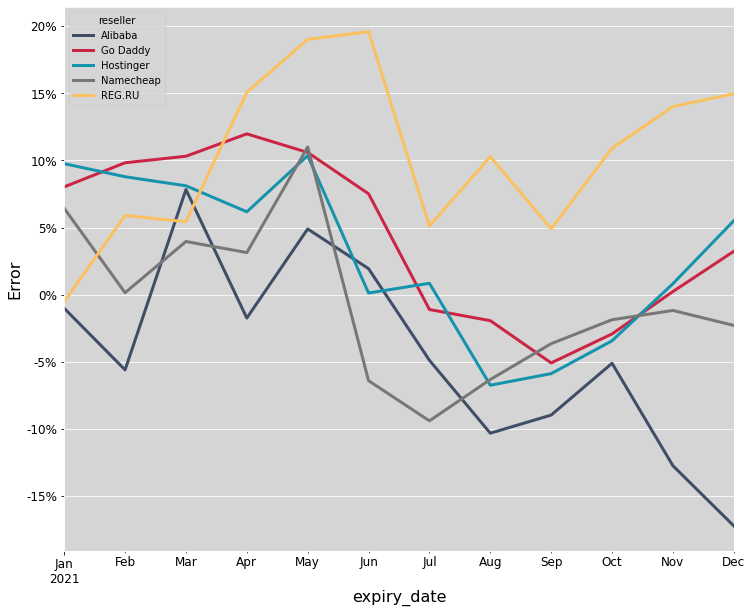

In [31]:
plt.style.use("ERI_template")
fig, ax = plt.subplots()
g_reseller.plot(ax=ax)
ax.yaxis.set_major_formatter("{x:.0%}")
ax.set_ylabel("Error")
plt.show()

In [ ]:
tmp = all_preds[all_preds.feature_set == "non_dp"].copy()

# Get top reseller
top_n = 10
mask = tmp.reseller.isin(tmp.reseller.value_counts().index[:top_n])

# Get groups
g = tmp[mask].groupby(["tld", "reseller", pd.Grouper(key="expiry_date", freq="MS")]).agg(
    prediction=("prediction", "sum"),
    renewed=("renewed", "sum"),
    count=("renewed", "count"),
).reset_index()
g.head(20)

tld      reseller expiry_date  prediction  renewed  count
0   fun  1&1 Internet  2021-04-01   39.666996       49     51
1   fun  1&1 Internet  2021-05-01    4.293215        5      7
2   fun  1&1 Internet  2021-06-01    9.767196       11     14
3   fun  1&1 Internet  2021-07-01   11.223859       15     16
4   fun  1&1 Internet  2021-08-01    6.459850        8      9
5   fun  1&1 Internet  2021-09-01   13.681929        1     18
6   fun  1&1 Internet  2021-10-01    5.399660        0      8
7   fun  1&1 Internet  2021-11-01    9.848096        0     14
8   fun  1&1 Internet  2021-12-01    6.088530        0      9
9   fun  1&1 Internet  2022-01-01    7.202783        0     12
10  fun  1&1 Internet  2022-02-01    9.050209        0     13
11  fun  1&1 Internet  2022-03-01   14.732618        0     21
12  fun  1&1 Internet  2022-04-01   40.658033        0     53
13  fun  1&1 Internet  2022-05-01    6.896438        0     12
14  fun  1&1 Internet  2022-06-01   11.559351        0     17
15  fun       Alibaba  2021-04-01  384.963974      382   1628
16  fun       Alibaba  2021-05-01  236.448224      232   1012
17  fun       Alibaba  2021-06-01  233.175808      262    874
18  fun       Alibaba  2021-07-01  554.410301      523   1523
19  fun       Alibaba  2021-08-01  263.236418      248   1124

In [ ]:
# Look at accuracy by reseller
g_ren = pd.pivot_table(g, index="expiry_date", columns="reseller", values="renewed", aggfunc="sum")
g_pred = pd.pivot_table(g, index="expiry_date", columns="reseller", values="prediction", aggfunc="sum")
g_reseller = (g_ren - g_pred) / g_ren
g_reseller.style.format("{:.1%}")

In [ ]:
# Look at accuracy by reseller
g_ren = pd.pivot_table(g, index="expiry_date", columns="reseller", values="renewed", aggfunc="sum")
g_pred = pd.pivot_table(g, index="expiry_date", columns="reseller", values="prediction", aggfunc="sum")
g_reseller = (g_ren - g_pred) / g_ren
g_reseller.style.format("{:.1%}")

In [22]:
g_ren

reseller     Alibaba  Beget  CHENGDU WEST  DNSPod     GMO  Go Daddy  \
expiry_date                                                           
2020-07-01    2312.0  303.0         535.0     NaN  2025.0    8019.0   
2020-08-01    1545.0  210.0         308.0     NaN  1653.0    7928.0   
2020-09-01    2023.0  120.0         321.0     NaN  1763.0    9310.0   
2020-10-01    2308.0  156.0         493.0     NaN  1940.0    9864.0   
2020-11-01    2899.0  139.0         910.0    63.0  2009.0    9662.0   
2020-12-01    2168.0  206.0         660.0   224.0  1991.0    7826.0   
2021-01-01    2242.0  498.0         545.0    95.0  2115.0   11600.0   
2021-02-01    1708.0  399.0         765.0   184.0  2053.0   11361.0   
2021-03-01    2783.0  410.0         854.0   207.0  2168.0   12778.0   
2021-04-01    2205.0  495.0        1212.0   159.0  2246.0   14095.0   
2021-05-01    2260.0  431.0         665.0   207.0  2179.0   14656.0   
2021-06-01    2118.0  380.0         556.0   229.0  1923.0   13618.0   

reseller     Hostinger  Namecheap  PDR China  REG.RU  
expiry_date                                           
2020-07-01       597.0     5672.0       23.0  1606.0  
2020-08-01       616.0     5359.0       11.0  1424.0  
2020-09-01       734.0     6206.0       24.0  1621.0  
2020-10-01       840.0     7292.0       21.0  1665.0  
2020-11-01      1127.0     8315.0       89.0  1696.0  
2020-12-01       912.0     6633.0       24.0  1699.0  
2021-01-01      1202.0     9485.0       49.0  2026.0  
2021-02-01       952.0     8213.0      178.0  2264.0  
2021-03-01      1201.0     8265.0      156.0  2419.0  
2021-04-01      1381.0     8277.0      234.0  2747.0  
2021-05-01      1596.0     9045.0       39.0  2482.0  
2021-06-01      1299.0     7163.0      221.0  2166.0

In [23]:
g_pred

reseller         Alibaba       Beget  CHENGDU WEST      DNSPod          GMO  \
expiry_date                                                                   
2020-07-01   1777.703607  194.165908    499.680366         NaN  2021.721419   
2020-08-01   1544.329727  197.897736    428.201747         NaN  1858.264396   
2020-09-01   1798.246490   95.233894    440.452448         NaN  1682.653668   
2020-10-01   2120.015868  106.639563    560.494414         NaN  1815.382561   
2020-11-01   2614.140357  104.095183    628.495035   64.095375  1829.572038   
2020-12-01   2026.487587  157.783159    776.522835  671.046343  1851.151514   
2021-01-01   2000.277929  273.999345    518.930447  147.987267  2039.468508   
2021-02-01   1655.264851  245.486232    718.830143  296.802804  1895.568250   
2021-03-01   2328.939628  247.067583    789.351747  210.765916  2129.901536   
2021-04-01   2050.415450  235.602068    970.793397  175.563161  2064.788261   
2021-05-01   1914.651312  205.006959    492.115323  176.325075  1906.076987   
2021-06-01   1884.682332  203.248469    407.242003  197.085385  1848.183014   

reseller        Go Daddy    Hostinger    Namecheap   PDR China       REG.RU  
expiry_date                                                                  
2020-07-01   7739.630324   810.380839  5531.914737   18.158140  1431.065966  
2020-08-01   7812.161077   974.870742  5858.051489   26.912572  1469.557513  
2020-09-01   7676.646997   971.181318  6300.839056   31.110169  1416.850458  
2020-10-01   8636.192842  1127.001050  6691.028705   33.784944  1668.924595  
2020-11-01   8075.442815  1166.091048  8142.111531   84.793281  1627.672697  
2020-12-01   6387.826369   945.963915  6541.548440   92.598044  1531.890274  
2021-01-01   9117.632238  1091.712596  8362.962837   75.898588  1756.863229  
2021-02-01   8644.453259   892.929243  7843.146728  168.546940  1816.793411  
2021-03-01   9668.453084  1092.360117  7494.138540   63.676735  1938.618585  
2021-04-01   9176.076659  1157.151419  7395.982467   34.826132  1960.896987  
2021-05-01   9721.190730  1267.074190  7183.508813   14.247585  1690.230273  
2021-06-01   9355.806747  1166.104437  6840.438042   45.508904  1469.444489

<AxesSubplot:xlabel='expiry_date'>

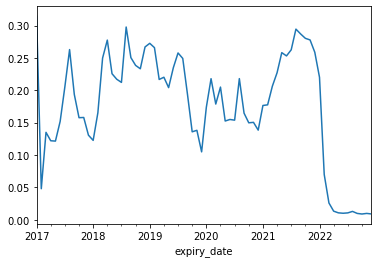

In [6]:
df.groupby(pd.Grouper(key="expiry_date", freq="MS"))["renewed"].mean().plot()

## Save Predictions

In [8]:
max_expiry_date = df.expiry_date.max().strftime("%Y-%m-%d")
all_preds.to_gbq(
    f"expiry.preds_lightgbm_2021-07-01_{max_expiry_date}",
    project_id = "myriad-303821",
    if_exists = "replace",
)

100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]
